In [1]:
%%capture
!pip install linearmodels
!pip install statsmodels
!pip install pymc3==3.11.4 theano-pymc==1.1.2 arviz

In [ ]:
# Libraries..
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import probplot
from scipy import stats
from sklearn.model_selection import learning_curve
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import skew, kurtosis
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, classification_report

Step-by-Step Statistical Analysis:

1. Loading and Preprocessing the Data - General metrics, null and duplicate values, defining variable types, variable transformations.

2. Descriptive Statistics and Visualizations - Frequency histograms, pie charts, box plots, scatter plots, correlation matrix heatmap.

3. ANOVA  Determine if there are significant differences in GPA across different levels of categorical
variables.

4. OLS Regression and Goodness of Fit - OLS with and w/o scaling, validating OLS assumptions, checking parameters for goodness of fit, power analysis, coefficients, residuals, and learning curve.

5. Feature Importance.

6. 'GradeClass' as a categorical 'GPA' Target variable - Visualization, Chi-square, t-test, and Logistic Regression.

7. Causal Inference analysis using propensity score - To analyze the causal effect of selected variables.

8. Bayesian Inference - Bayesian Regression, plotting residuals and Posterior Predictive Distribution.


# 1. Loading and Preprocessing the Data

In [ ]:
# Loading the data and getting basic metrics
df = pd.read_csv('Student_performance_data _.csv')
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB
         StudentID      

In [ ]:
# Null and duplicate values
# Checking for null values
null_values = df.isnull().sum()

# Checking for duplicates in the 'StudentID' column (checking for duplicate student entries)
duplicates = df['StudentID'].duplicated().sum()

# Checking for null values and duplicates
print("Number of null values in each column:\n", df.isnull().sum())
print("Number of duplicates in 'StudentID':", df['StudentID'].duplicated().sum())

Number of null values in each column:
 StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64
Number of duplicates in 'StudentID': 0


Variables by input type in the dataset:

- StudentID, Unique Number, int64

Integers:
- Age, 15 - 18, int64
- Absences, 0 -29, int64

Floats:
- StudyTimeWeekly, 0 - 20, float
- GPA, 0 - 4, float
- GradeClass, 0 - 4, float

Binary:
- Gender
- Tutoring
- Extracurricular
- Sports
- Music
- Volunteering

Ordinal:
- ParentalEducation, 0 - 4, int64
- ParentalSupport, 0 - 4, int64

Other:
- Ethnicity, 0 - 3, int64

In [ ]:
''' Defining variables:
- To be dropped from the dataframe
StudentID - after ansuring there are no duplicates this column is to be dropped from the dataframe, it's not necessary for
analysis.

- Numerical Variables
'Age', 'StudyTimeWeekly', 'Absences'

- Categorical Variables, Binary
'Gender', 'Tutoring',  'Extracurricular', 'Sports', 'Music', 'Volunteering'

- Ordinal Variables
'ParentalEducation', 'ParentalSupport'

- Categorical variable to be encoded by one-hot coding for better variable representation
'Ethnicity'

- Target Variable
'GPA' (continuous, float64)

- 'GradeClass' will not be assigned into a particular analysis at this point, will be used later in the analysis as a categorical representation of 'GPA'.
'''
# Defining a new dataframe which will be preprocessed for analysis
corrected_df = df.copy()

# Dropping the 'StudentID' column
corrected_df = corrected_df.drop(columns=['StudentID'])

# Oridnal Variables
ordinal_vars = ['ParentalSupport', 'ParentalEducation']
# Ensuring 'ParentalSupport' and 'ParentalEducation' are correctly treated as ordinal, int
corrected_df['ParentalSupport'] = corrected_df['ParentalSupport'].astype(int)
corrected_df['ParentalEducation'] = corrected_df['ParentalEducation'].astype(int)

# One-hot encoding the 'Ethnicity' variable and renaming columns
# Mapping dictionary
ethnicity_map = {
    0: 'Caucasian',
    1: 'African_American',
    2: 'Asian',
    3: 'Other'
}

corrected_df = pd.get_dummies(corrected_df, columns=['Ethnicity'])

# Convert boolean columns to integers
corrected_df = corrected_df.astype({col: 'int32' for col in corrected_df.columns if 'Ethnicity_' in col})

# Rename the columns using the mapping dictionary
new_column_names = {}
for col in corrected_df.columns:
    if 'Ethnicity_' in col:
        # Extract the integer code from the column name and map it to the ethnicity
        code = int(col.split('_')[-1])
        new_column_names[col] = f'Ethnicity_{ethnicity_map[code]}'

# Apply the renaming to the dataframe
corrected_df = corrected_df.rename(columns=new_column_names)

# Ensuring binary variables are correctly typed as integers
binary_vars = ['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
for var in binary_vars:
    corrected_df[var] = corrected_df[var].astype(int)

# Numerical Variables
numerical_vars = ['Age', 'StudyTimeWeekly', 'Absences']

# Ensure that GPA and other numerical variables are correctly typed as floats
corrected_df['GPA'] = corrected_df['GPA'].astype(float)
corrected_df['StudyTimeWeekly'] = corrected_df['StudyTimeWeekly'].astype(float)

# Checking the preprocessed dataframe
print(corrected_df.head())

# Checking the data types
print(corrected_df.dtypes)


   Age  Gender  ParentalEducation  StudyTimeWeekly  Absences  Tutoring  \
0   17       1                  2        19.833723         7         1   
1   18       0                  1        15.408756         0         0   
2   15       0                  3         4.210570        26         0   
3   17       1                  3        10.028829        14         0   
4   17       1                  2         4.672495        17         1   

   ParentalSupport  Extracurricular  Sports  Music  Volunteering       GPA  \
0                2                0       0      1             0  2.929196   
1                1                0       0      0             0  3.042915   
2                2                0       0      0             0  0.112602   
3                3                1       0      0             0  2.054218   
4                3                0       0      0             0  1.288061   

   GradeClass  Ethnicity_Caucasian  Ethnicity_African_American  \
0         2.0       

In [ ]:
# Outliers detection by IQR and Z-score
# Function to perform IQR outlier detection
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Function to perform Z-score outlier detection
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column])
    outliers = df[(z_scores < -threshold) | (z_scores > threshold)]
    return outliers

# Creating a copy of the dataframe for outlier detection
df_outlier_check = corrected_df.copy()

# List of numerical variables to apply outlier detection
numerical_vars_outliers = ['GPA', 'StudyTimeWeekly', 'Absences', 'Age']

# Detecting outliers using IQR and Z-score methods on the copy
for var in numerical_vars_outliers:
    outliers_iqr = detect_outliers_iqr(df_outlier_check, var)
    outliers_zscore = detect_outliers_zscore(df_outlier_check, var)
    print(f'Number of outliers detected in {var} using IQR method: {len(outliers_iqr)}')
    print(f'Number of outliers detected in {var} using Z-score method: {len(outliers_zscore)}')

# Checking that the original dataframe is unaffected
print("Original dataframe description:")
print(corrected_df.describe())

# Confirming that the copy used for outlier detection does not affect the original dataframe
print("Dataframe copy used for outlier detection description:")
print(df_outlier_check.describe())

Number of outliers detected in GPA using IQR method: 0
Number of outliers detected in GPA using Z-score method: 0
Number of outliers detected in StudyTimeWeekly using IQR method: 0
Number of outliers detected in StudyTimeWeekly using Z-score method: 0
Number of outliers detected in Absences using IQR method: 0
Number of outliers detected in Absences using Z-score method: 0
Number of outliers detected in Age using IQR method: 0
Number of outliers detected in Age using Z-score method: 0
Original dataframe description:
               Age       Gender  ParentalEducation  StudyTimeWeekly  \
count  2392.000000  2392.000000        2392.000000      2392.000000   
mean     16.468645     0.510870           1.746237         9.771992   
std       1.123798     0.499986           1.000411         5.652774   
min      15.000000     0.000000           0.000000         0.001057   
25%      15.000000     0.000000           1.000000         5.043079   
50%      16.000000     1.000000           2.000000  

# 2. Descriptive Statistics and Visualizations

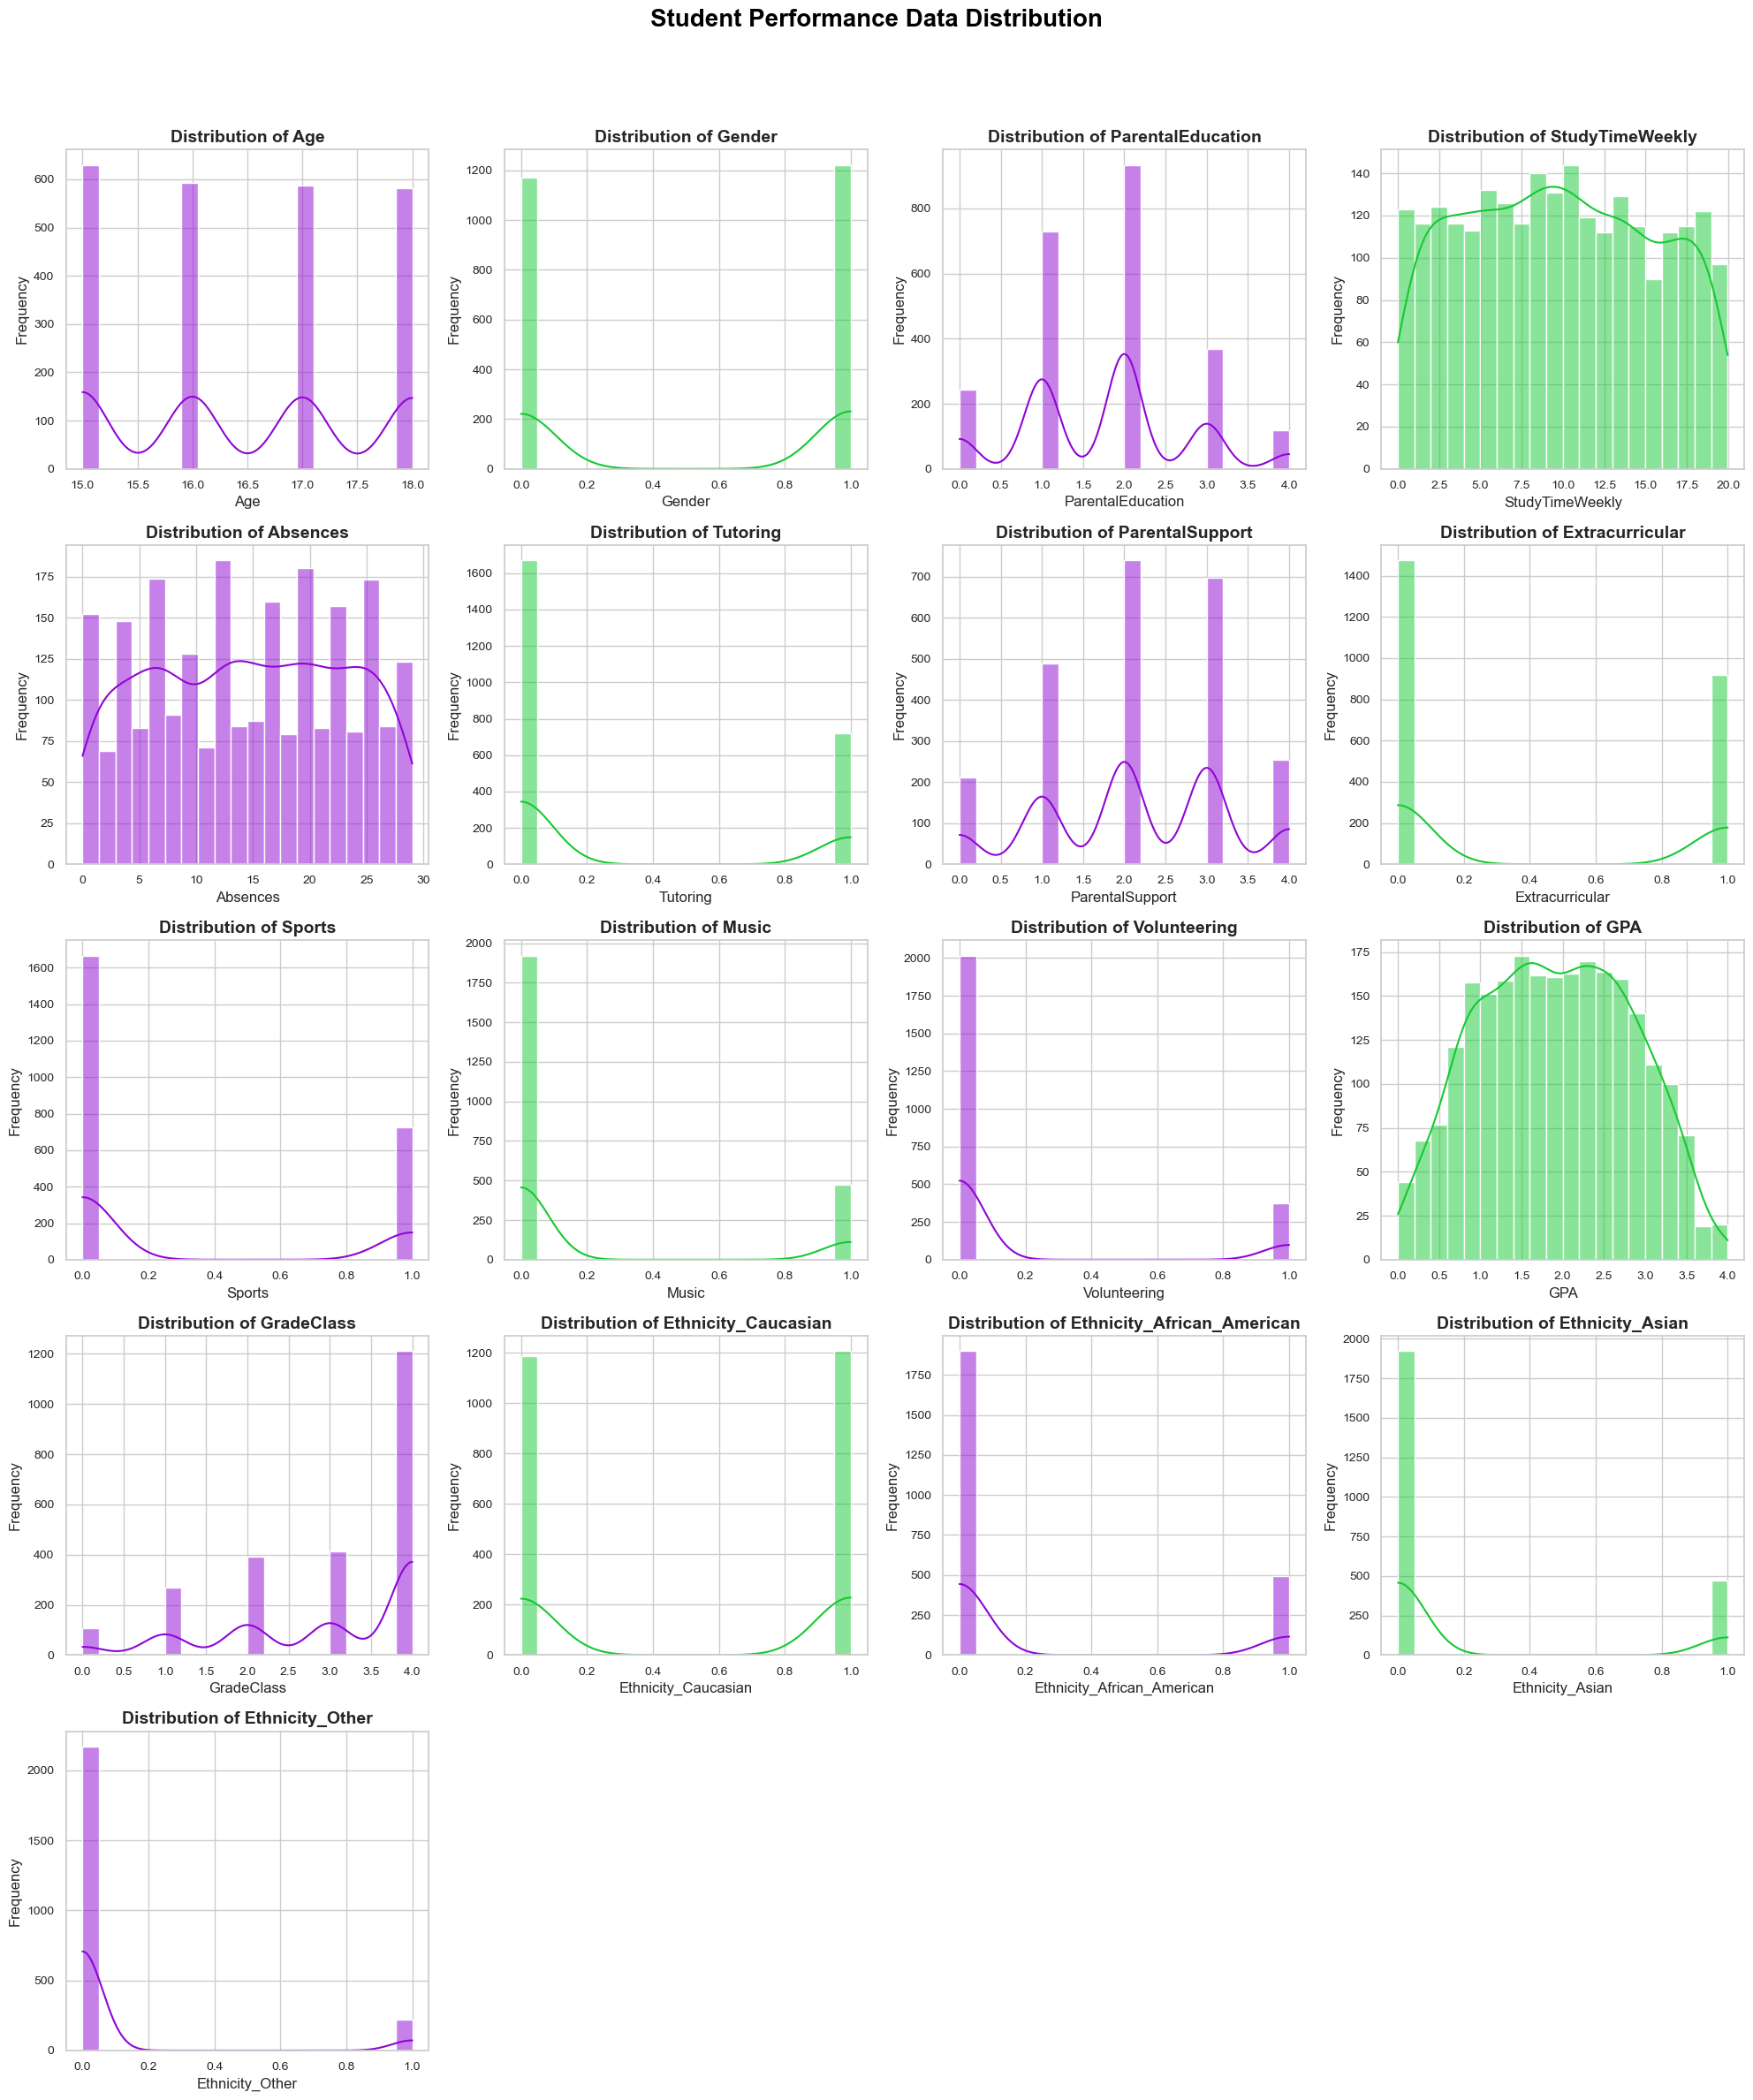

In [ ]:
# Frequency Distributions
# Defining custom colors for the plots
# Define specific colors
colors = ['#8e05d5', '#15c932']  # Deep Purple and Lime Green

sns.set(style="whitegrid")

# Defining the number of columns for the plot grid
n_cols = 4

# Calculating the number of rows required
n_rows = (len(corrected_df.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plotting histograms for variables
for i, col in enumerate(corrected_df.columns):
    color = colors[i % len(colors)]  # Alternate colors
    sns.histplot(corrected_df[col], bins=20, kde=True, ax=axes[i], color=color)
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=10)

# Adding a background color to the figure
#fig.patch.set_facecolor('white')
fig.suptitle('Student Performance Data Distribution', fontsize=20, fontweight='bold', color='black')

for i in range(len(corrected_df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# List of variables for which to calculate skewness and kurtosis
variables = ['GPA', 'StudyTimeWeekly']

# Calculate skewness and kurtosis for each variable
for var in variables:
    skewness = skew(corrected_df[var])
    kurt = kurtosis(corrected_df[var], fisher=False)  # fisher=False gives the Pearson definition (normal distribution = 3)
    print(f"Variable: {var}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurt}\n")

Variable: GPA
Skewness: 0.014516490896101894
Kurtosis: 2.1360192231500648

Variable: StudyTimeWeekly
Skewness: 0.050036669884928095
Kurtosis: 1.8641830384005285



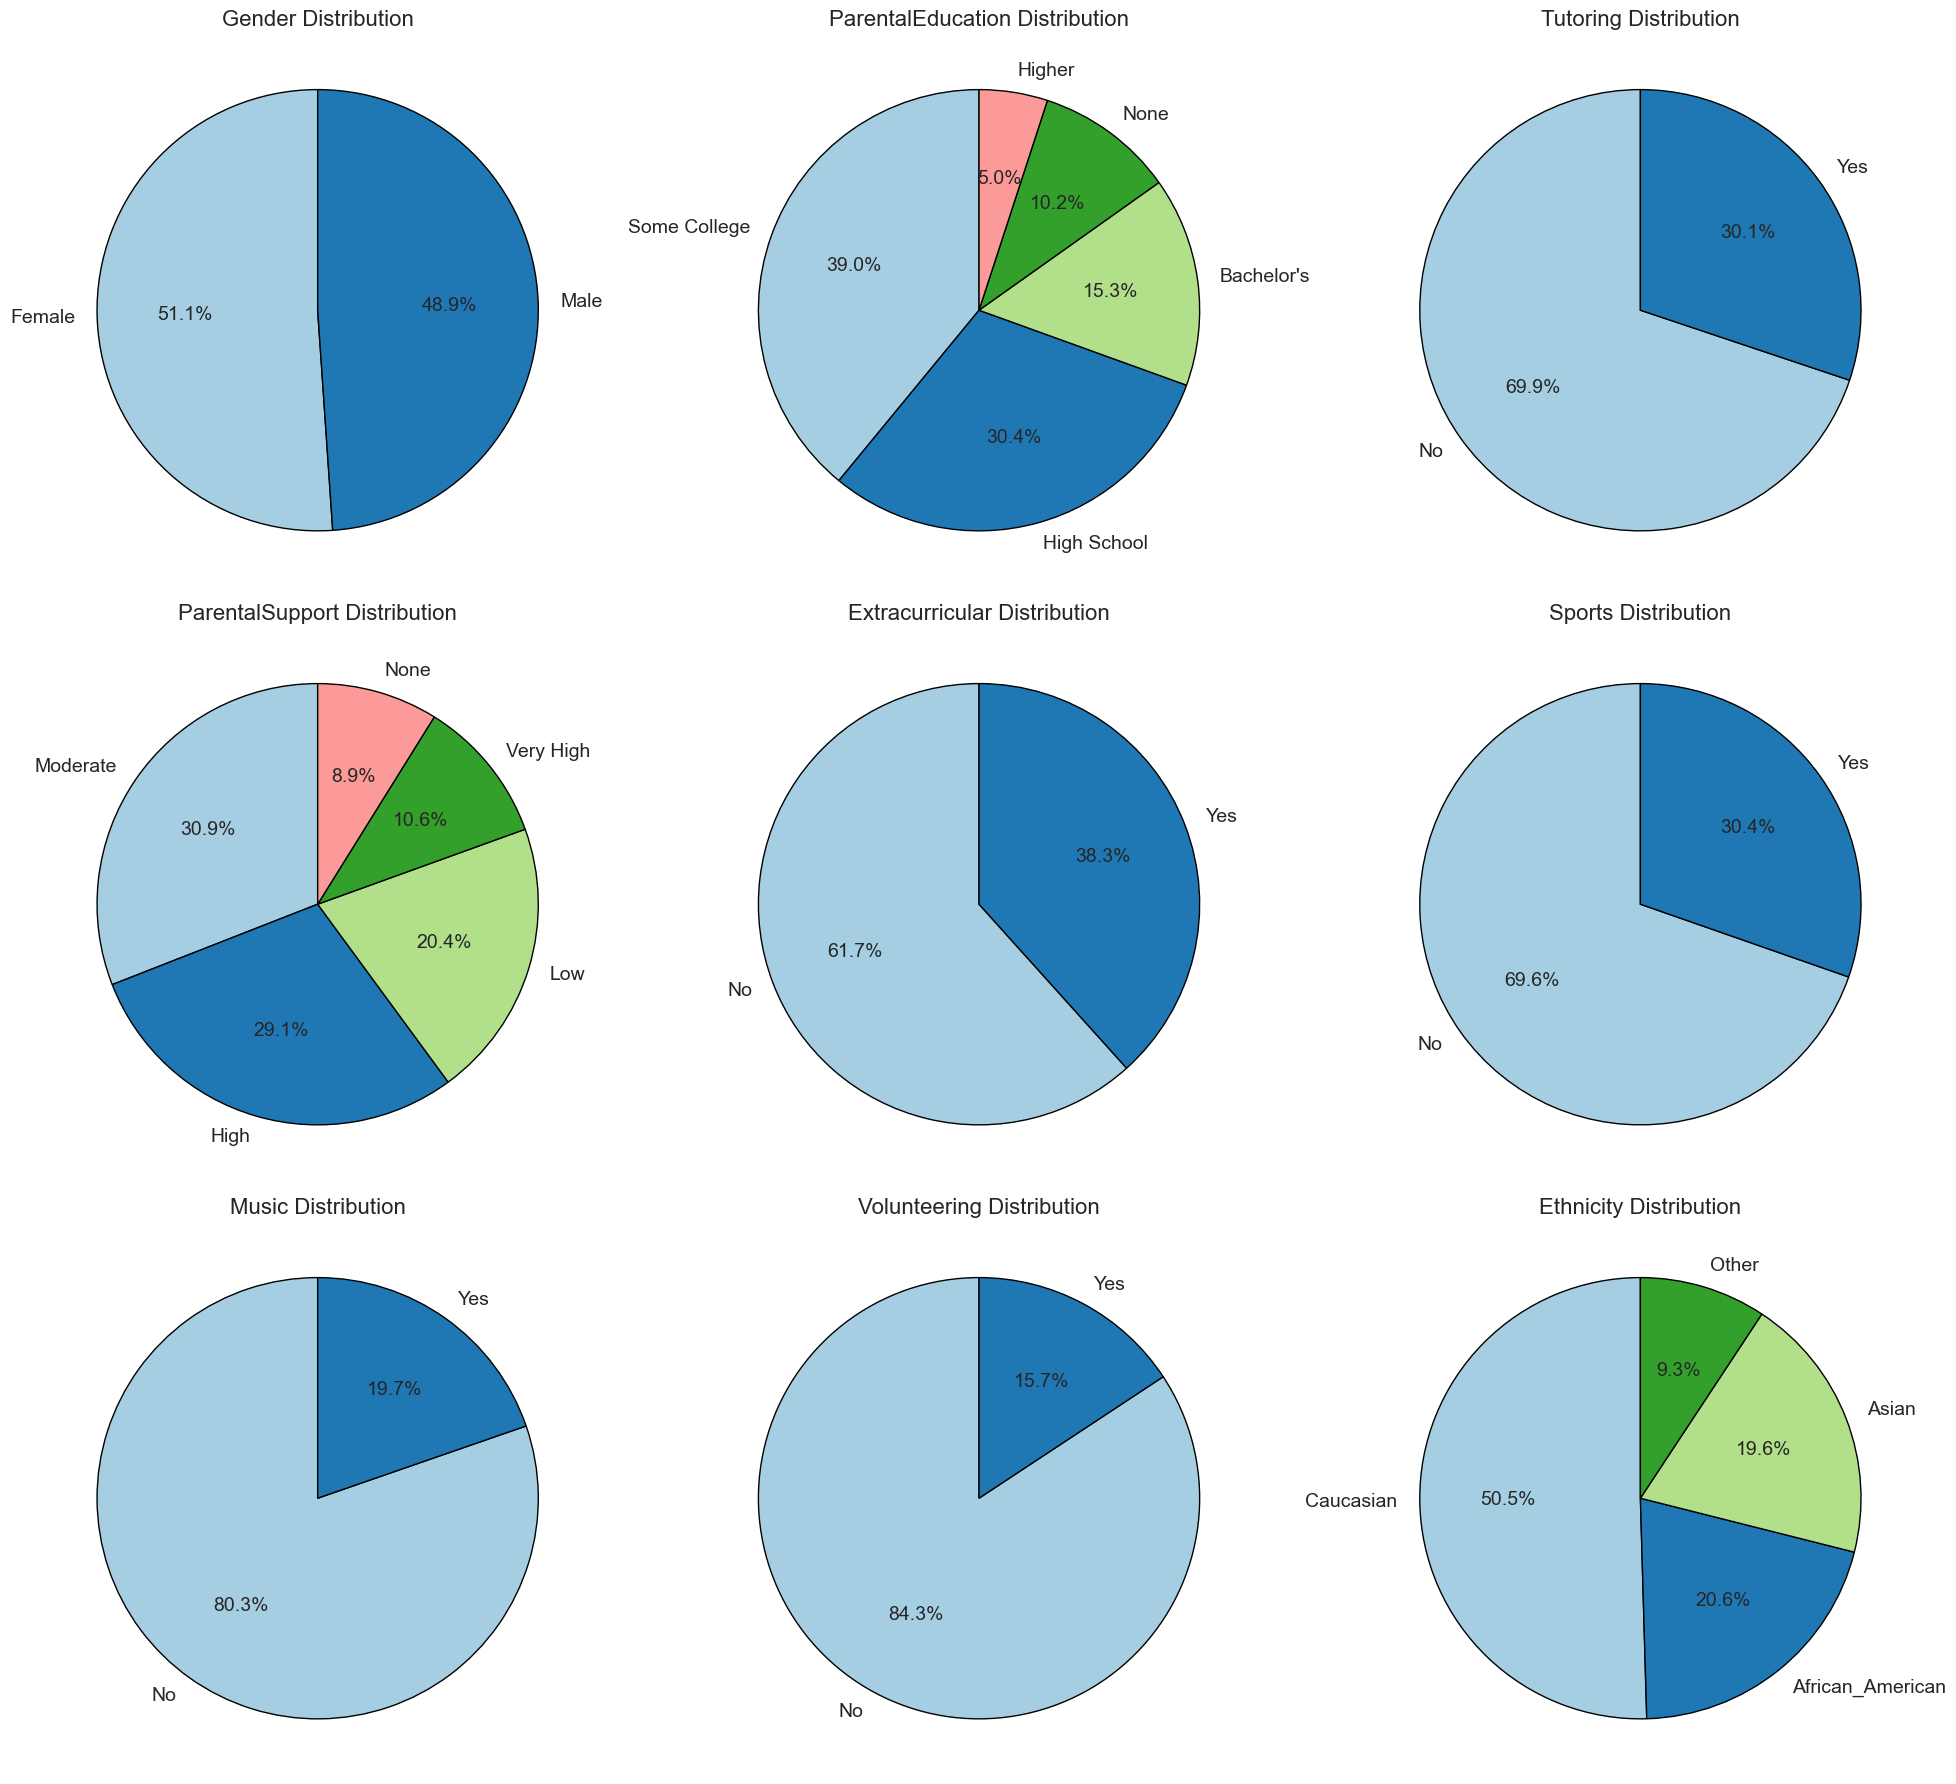

In [ ]:
# Pie Charts for categorical values
# Creating a copy of the DataFrame for plotting purposes
df_plot = corrected_df.copy()

# Creating a new 'Ethnicity' column by mapping the one-hot encoded columns back to their category names
ethnicity_columns = ['Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian', 'Ethnicity_Other']
df_plot['Ethnicity'] = df_plot[ethnicity_columns].idxmax(axis=1)
df_plot['Ethnicity'] = df_plot['Ethnicity'].str.replace('Ethnicity_', '')

# Mapping numerical values to category names for other variables
df_plot['Gender'] = df_plot['Gender'].map({0: 'Male', 1: 'Female'})
df_plot['ParentalEducation'] = df_plot['ParentalEducation'].map({0: 'None', 1: 'High School', 2: 'Some College', 3: 'Bachelor\'s', 4: 'Higher'})
df_plot['Tutoring'] = df_plot['Tutoring'].map({0: 'No', 1: 'Yes'})
df_plot['ParentalSupport'] = df_plot['ParentalSupport'].map({0: 'None', 1: 'Low', 2: 'Moderate', 3: 'High', 4: 'Very High'})
df_plot['Extracurricular'] = df_plot['Extracurricular'].map({0: 'No', 1: 'Yes'})
df_plot['Sports'] = df_plot['Sports'].map({0: 'No', 1: 'Yes'})
df_plot['Music'] = df_plot['Music'].map({0: 'No', 1: 'Yes'})
df_plot['Volunteering'] = df_plot['Volunteering'].map({0: 'No', 1: 'Yes'})

# List of categorical variables to plot
categorical_vars = ['Gender', 'ParentalEducation', 'Tutoring', 'ParentalSupport',
                    'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Ethnicity']

# Defining the number of columns for the plot grid
n_cols = 3

# Calculating the number of rows required
n_rows = (len(categorical_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

# Pie charts for each categorical variable
for i, var in enumerate(categorical_vars):
    df_plot[var].value_counts().plot.pie(ax=axes[i], autopct='%1.1f%%', startangle=90,
                                    colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'},
                                    textprops={'fontsize': 14})  # Adjust the fontsize as needed
    axes[i].set_title(f'{var} Distribution', fontsize=16)  # Adjust the title fontsize as needed
    axes[i].set_ylabel('')  # Remove y-label to avoid clutter

# Removing any empty subplots
for i in range(len(categorical_vars), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\1497042459.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=predictor, y='GPA', data=corrected_df, ax=axes[i], palette=[color])
C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\1497042459.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x=predictor, y='GPA', data=corrected_df, ax=axes[i], palette=[color])
C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\1497042459.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=predictor, y='GPA', data=corrected_df, ax=axes[i], palette=[color])
C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\14970

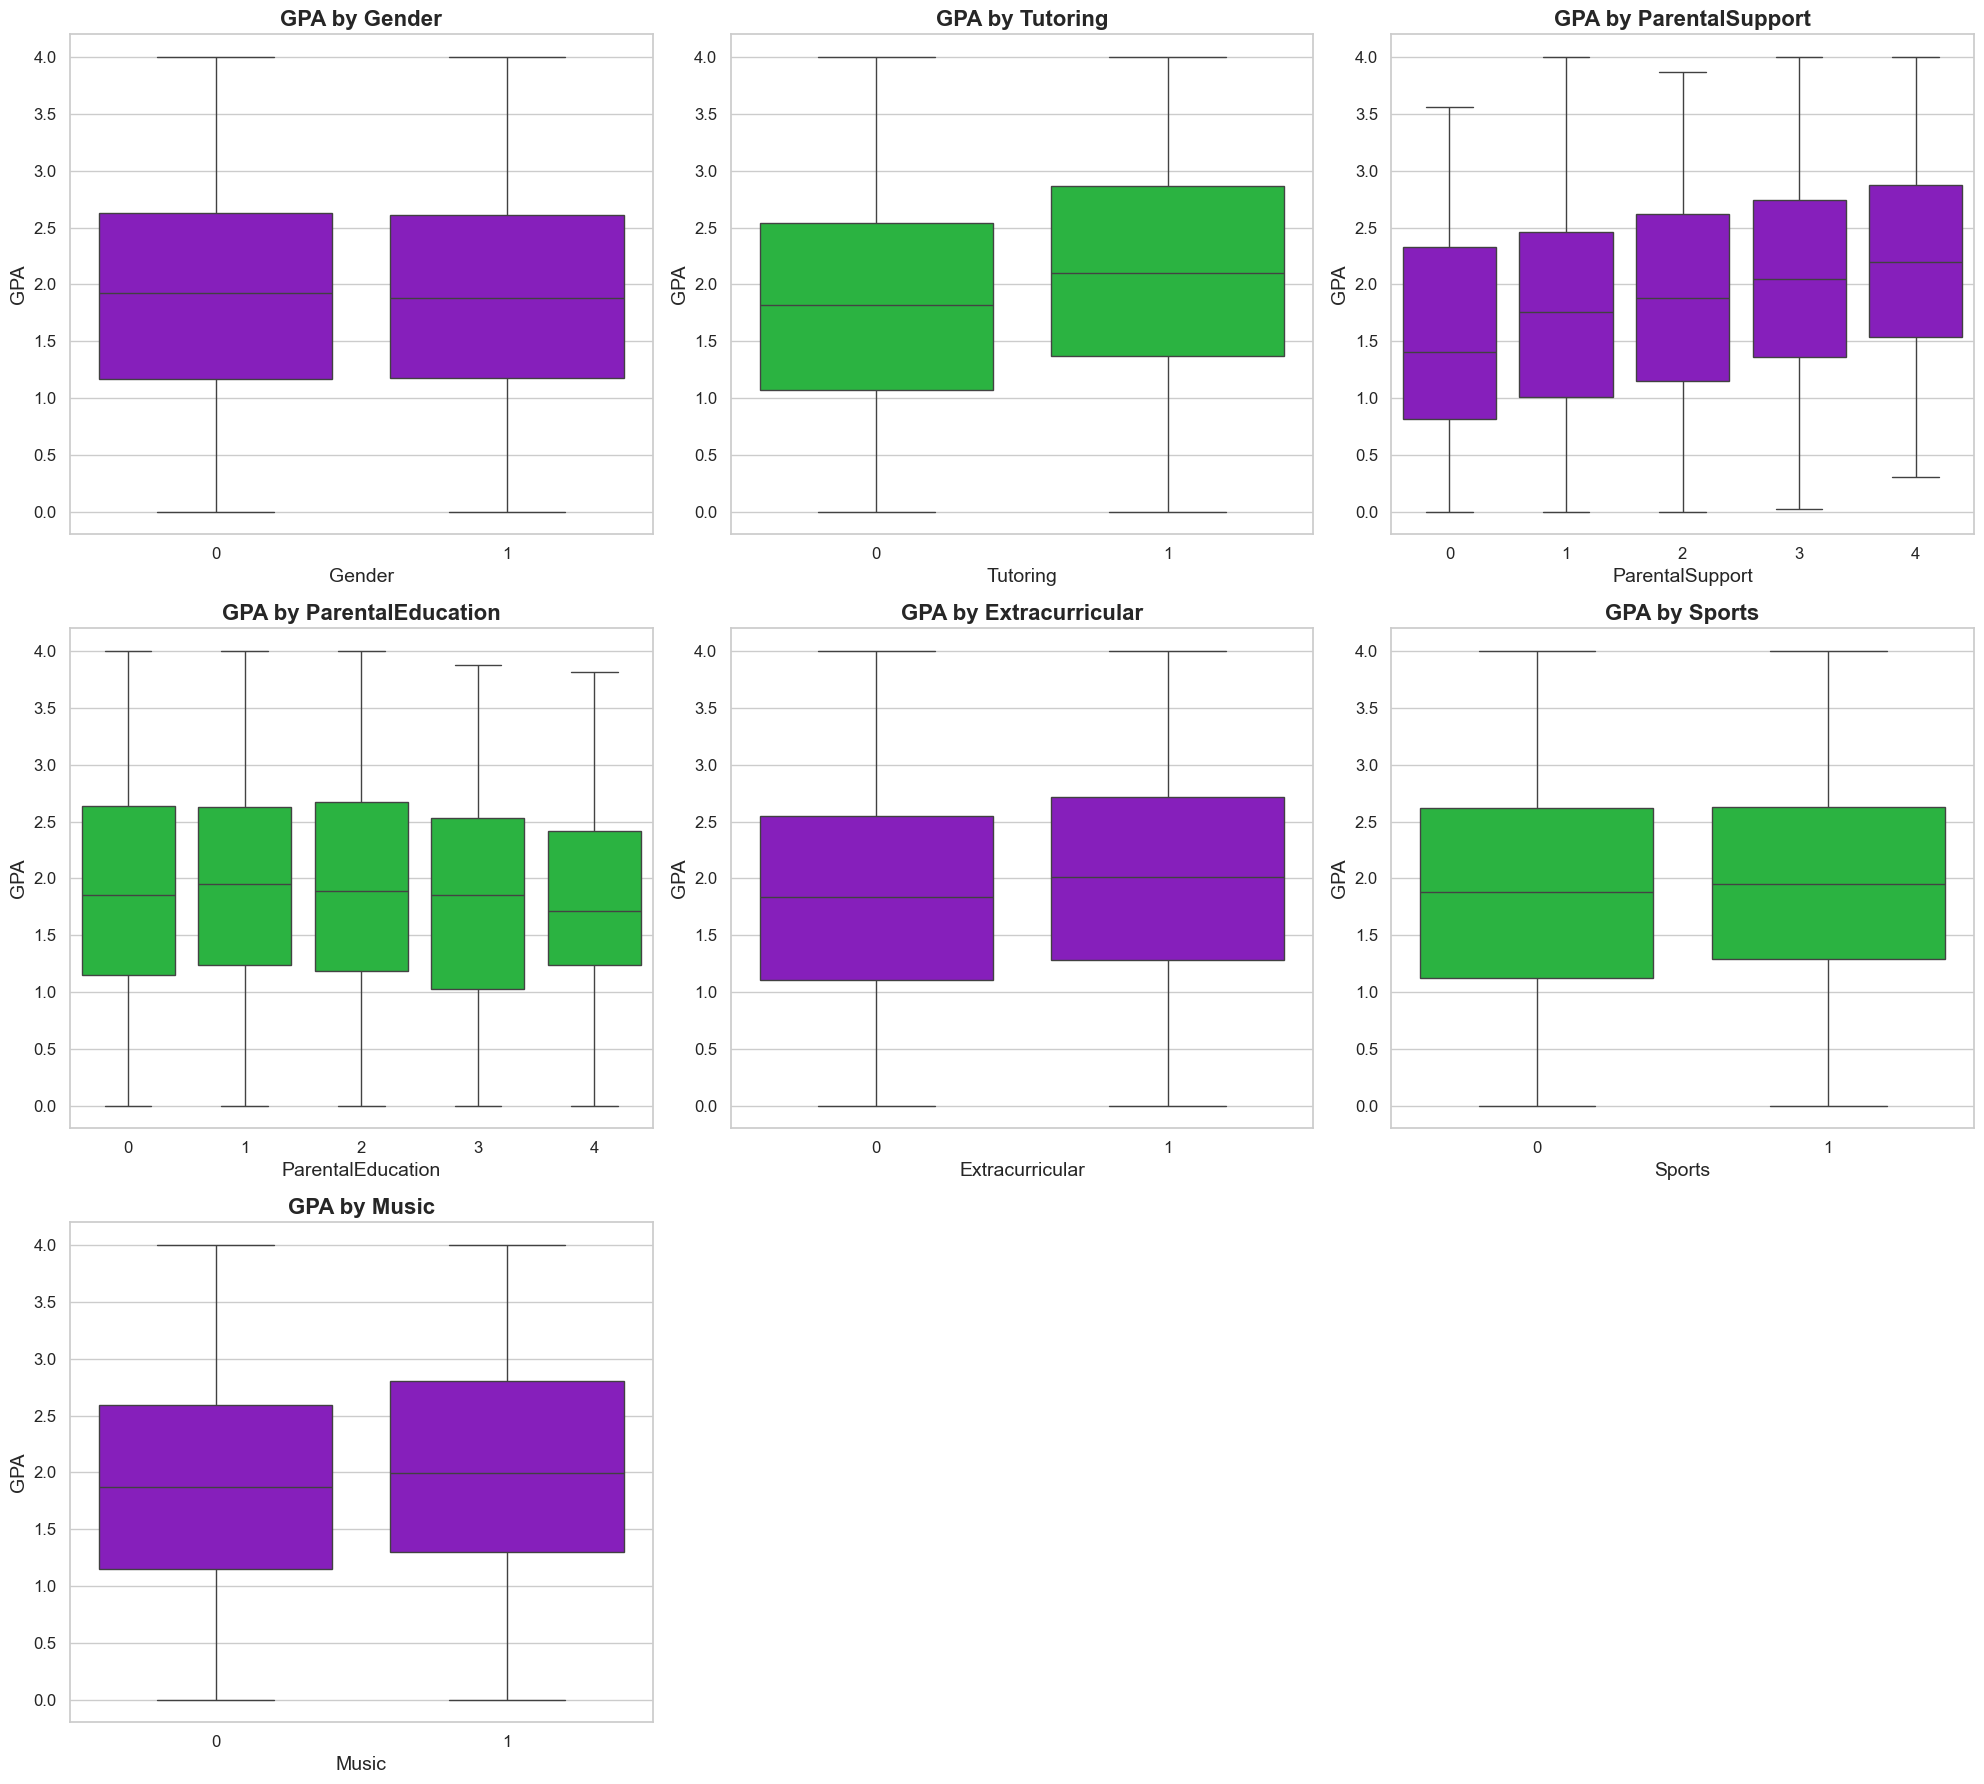

In [ ]:
# Box Plots for GPA by selected discrete variables
# Defining custom colors for the box plots
colors = ['#8e05d5', '#15c932']  # Deep Purple and Lime Green

sns.set(style="whitegrid")

# List of categorical predictors to plot
categorical_predictors = ['Gender', 'Tutoring', 'ParentalSupport', 'ParentalEducation', 'Extracurricular', 'Sports', 'Music']

# Defining the number of columns per row
n_cols = 3
n_rows = (len(categorical_predictors) + n_cols - 1) // n_cols

# Creating box plots for each categorical predictor
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for i, predictor in enumerate(categorical_predictors):
    color = colors[i % len(colors)]  # Alternate colors
    sns.boxplot(x=predictor, y='GPA', data=corrected_df, ax=axes[i], palette=[color])
    axes[i].set_title(f'GPA by {predictor}', fontsize=16, fontweight='bold')
    axes[i].set_xlabel(predictor, fontsize=14)
    axes[i].set_ylabel('GPA', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

# Removing any empty subplots
for i in range(len(categorical_predictors), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

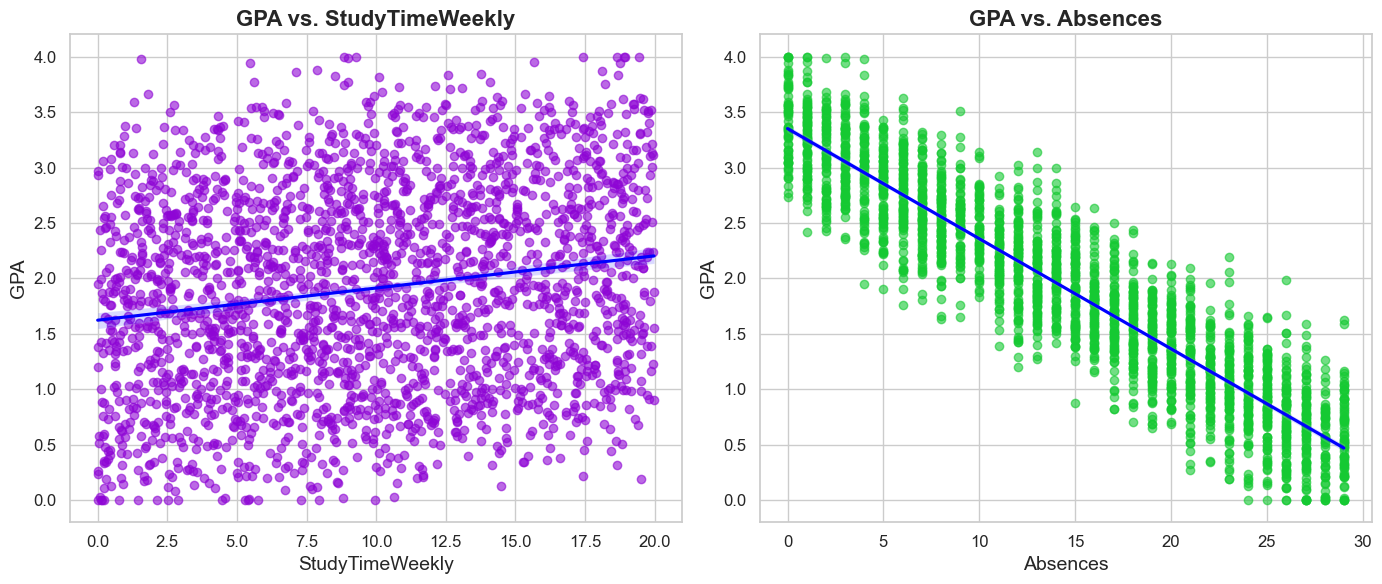

In [ ]:
# Scatter Plots for GPA by StudyTimeWeekly and Absences
# Defining custom colors for the scatter plots
colors = ['#8e05d5', '#15c932']

sns.set(style="whitegrid")

# Defining the continuous predictors
continuous_predictors = ['StudyTimeWeekly', 'Absences']

# Creating scatter plots with regression lines for each continuous predictor
fig, axes = plt.subplots(1, len(continuous_predictors), figsize=(14, 6))

for i, predictor in enumerate(continuous_predictors):
    color = colors[i % len(colors)]  # Alternate colors
    sns.regplot(x=predictor, y='GPA', data=corrected_df, ax=axes[i], scatter_kws={'color': color, 'alpha': 0.6}, line_kws={'color': '#0000ff'})
    axes[i].set_title(f'GPA vs. {predictor}', fontsize=16, fontweight='bold')
    axes[i].set_xlabel(predictor, fontsize=14)
    axes[i].set_ylabel('GPA', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Checking the preprocessed dataframe
print(corrected_df.head())

# Checking the data types
print(corrected_df.dtypes)

   Age  Gender  ParentalEducation  StudyTimeWeekly  Absences  Tutoring  \
0   17       1                  2        19.833723         7         1   
1   18       0                  1        15.408756         0         0   
2   15       0                  3         4.210570        26         0   
3   17       1                  3        10.028829        14         0   
4   17       1                  2         4.672495        17         1   

   ParentalSupport  Extracurricular  Sports  Music  Volunteering       GPA  \
0                2                0       0      1             0  2.929196   
1                1                0       0      0             0  3.042915   
2                2                0       0      0             0  0.112602   
3                3                1       0      0             0  2.054218   
4                3                0       0      0             0  1.288061   

   GradeClass  Ethnicity_Caucasian  Ethnicity_African_American  \
0         2.0       

   Age  Gender  ParentalEducation  StudyTimeWeekly  Absences  Tutoring  \
0   17       1                  2        19.833723         7         1   
1   18       0                  1        15.408756         0         0   
2   15       0                  3         4.210570        26         0   
3   17       1                  3        10.028829        14         0   
4   17       1                  2         4.672495        17         1   

   ParentalSupport  Extracurricular  Sports  Music  Volunteering       GPA  \
0                2                0       0      1             0  2.929196   
1                1                0       0      0             0  3.042915   
2                2                0       0      0             0  0.112602   
3                3                1       0      0             0  2.054218   
4                3                0       0      0             0  1.288061   

   Ethnicity_Caucasian  Ethnicity_African_American  Ethnicity_Asian  \
0              

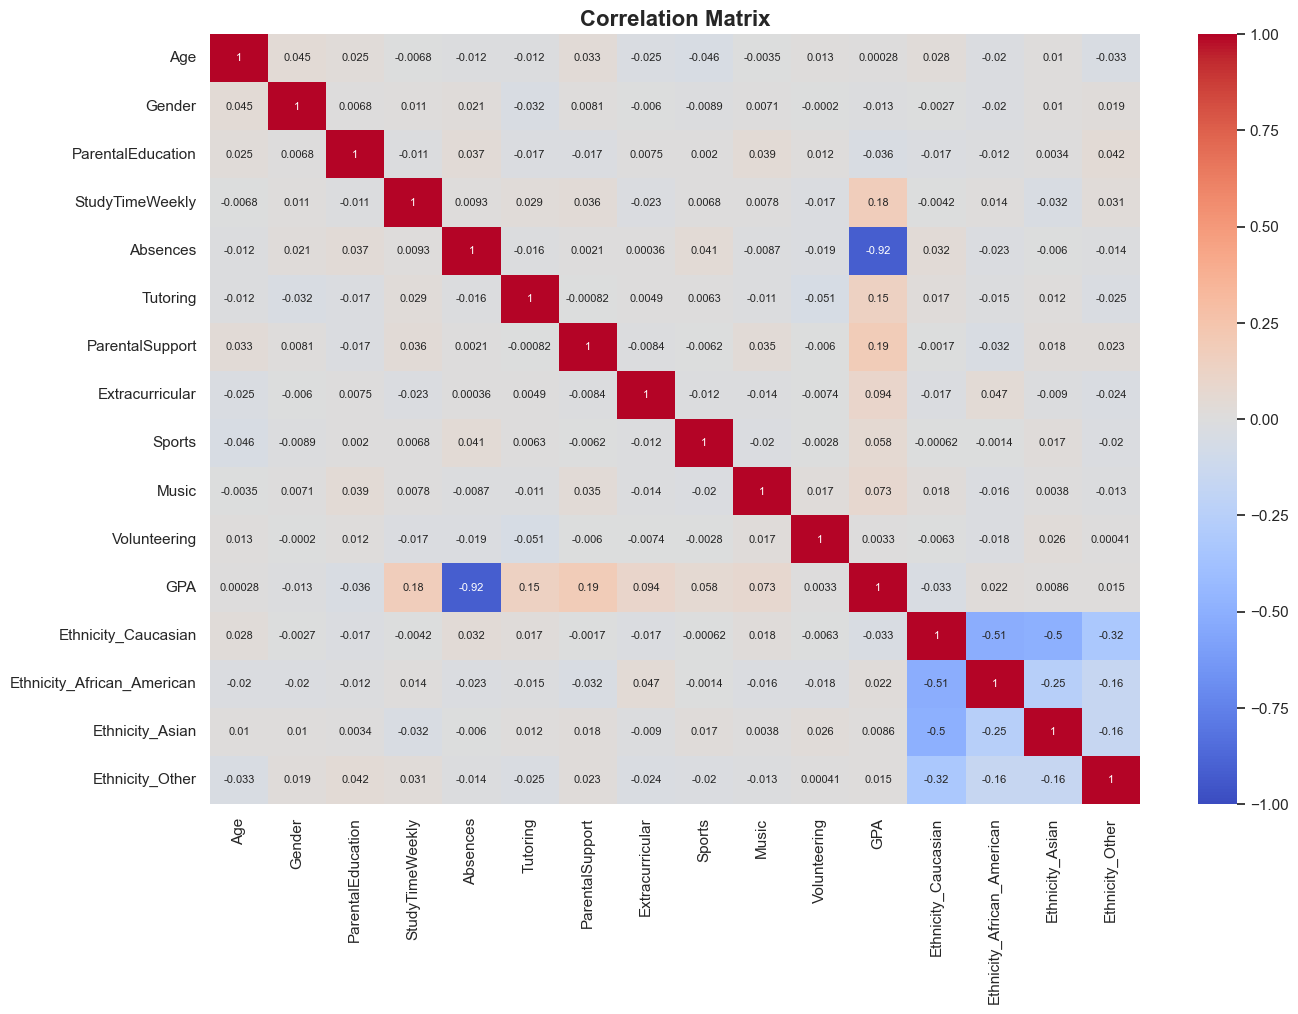

In [ ]:
# Plotting Correlation Matrix
# A dataframe without 'GradeClass' for plotting the correlation matrix
matrix_df = corrected_df.copy()
matrix_df = matrix_df.drop(columns=['GradeClass'])

# Checking the preprocessed dataframe
print(matrix_df.head())

# Checking the data types
print(matrix_df.dtypes)

# Computing the correlation matrix
corr_matrix = matrix_df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

# 3. ANOVA Analysis

ANOVA Hypothesis:

One-way Null Hypothesis:
\begin{align*}
H_0: & \quad \mu_1 = \mu_2 = \mu_3 = \ldots = \mu_k
\end{align*}

Alternate Hypothesis:

\begin{align*}
H_1: & \quad \text{Not all group means } \mu_i \text{ are equal}
\end{align*}

Two-way ANOVA:



Null Hypotheses
\begin{align*}
H_{0A}: & \quad \mu_{A1} = \mu_{A2} = \mu_{A3} = \ldots = \mu_{Ak} & \text{(Factor A)}\\
H_{0B}: & \quad \mu_{B1} = \mu_{B2} = \mu_{B3} = \ldots = \mu_{Bl} & \text{(Factor B)}\\
H_{0AB}: & \quad \text{There is no interaction effect between Factor A and Factor B} & \text{(Interaction)}
\end{align*}

Alternate Hypotheses
\textbf{Alternate Hypotheses:}
\begin{align*}
H_{1A}: & \quad \text{Not all group means } \mu_{Ai} \text{ are equal} & \text{(Factor A)}\\
H_{1B}: & \quad \text{Not all group means } \mu_{Bi} \text{ are equal} & \text{(Factor B)}\\
H_{1AB}: & \quad \text{There is an interaction effect between Factor A and Factor B} & \text{(Interaction)}
\end{align*}



In [ ]:
# ANOVA Analysis for categorical variables
# Code can be modified to contain various combinations of categorical variables
categorical_vars_corrected = ['Gender', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian', 'Ethnicity_Other']

anova_results = {}
for var in categorical_vars_corrected:
    model_anova = ols(f'GPA ~ C({var})', data=corrected_df).fit()
    anova_table = anova_lm(model_anova, typ=2)
    anova_results[var] = anova_table

print("ANOVA Analysis Results:")
for var, results in anova_results.items():
    print(f"\nANOVA for {var}:\n", results)


ANOVA Analysis Results:

ANOVA for Gender:
                 sum_sq      df         F    PR(>F)
C(Gender)     0.357422     1.0  0.426665  0.513693
Residual   2002.129408  2390.0       NaN       NaN

ANOVA for ParentalEducation:
                            sum_sq      df        F    PR(>F)
C(ParentalEducation)     6.049132     4.0  1.80813  0.124484
Residual              1996.437697  2387.0      NaN       NaN

ANOVA for Tutoring:
                   sum_sq      df          F        PR(>F)
C(Tutoring)    42.171373     1.0  51.414981  9.923854e-13
Residual     1960.315456  2390.0        NaN           NaN

ANOVA for ParentalSupport:
                          sum_sq      df          F        PR(>F)
C(ParentalSupport)    73.455005     4.0  22.723458  1.906551e-18
Residual            1929.031825  2387.0        NaN           NaN

ANOVA for Extracurricular:
                          sum_sq      df          F    PR(>F)
C(Extracurricular)    17.723471     1.0  21.342139  0.000004
Residual          

In [ ]:
# One-way ANOVA for Continuous variable after categorization
df_ANOVA = corrected_df.copy()
df_ANOVA['StudyTimeGroup'] = pd.cut(df_ANOVA['StudyTimeWeekly'], bins=[0, 10, 20, float('inf')], labels=['Low', 'Medium', 'High'])

# Run ANOVA for StudyTimeGroup
model_study_time = ols('GPA ~ C(StudyTimeGroup)', data=df_ANOVA).fit()
anova_table_study_time = anova_lm(model_study_time, typ=2)

print("ANOVA for StudyTimeWeekly (categorized):")
print(anova_table_study_time)

ANOVA for StudyTimeWeekly (categorized):
                        sum_sq      df          F        PR(>F)
C(StudyTimeGroup)    90.424809     2.0  55.208225  1.500971e-13
Residual           1957.274425  2390.0        NaN           NaN


C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# One-way ANOVA for Continuous variable after categorization
df_ANOVA['AbsencesGroup'] = pd.cut(df_ANOVA['Absences'], bins=[0, 15, 30, float('inf')], labels=['Low', 'Medium', 'High'])

# Run ANOVA for AbsencesGroup
model_absences = ols('GPA ~ C(AbsencesGroup)', data=df_ANOVA).fit()
anova_table_absences = anova_lm(model_absences, typ=2)

print("ANOVA for Absences (categorized):")
print(anova_table_absences)

ANOVA for Absences (categorized):
                       sum_sq      df            F  PR(>F)
C(AbsencesGroup)  2332.370673     2.0  4016.219816     0.0
Residual           674.526959  2323.0          NaN     NaN


C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Two-way ANOVA for 'StudyTimeWeekly' and 'Absences’'
# Running the two-way ANOVA

formula = 'GPA ~ C(StudyTimeGroup) + C(AbsencesGroup) + C(StudyTimeGroup):C(AbsencesGroup)'

model_interaction = ols(formula, data=df_ANOVA).fit()
anova_results_interaction = anova_lm(model_interaction, typ=2)

# Printing results
print("Two-way ANOVA results:")
print(anova_results_interaction)

Two-way ANOVA results:
                                        sum_sq      df         F    PR(>F)
C(StudyTimeGroup)                          NaN     2.0       NaN       NaN
C(AbsencesGroup)                           NaN     2.0       NaN       NaN
C(StudyTimeGroup):C(AbsencesGroup)    0.002821     4.0  0.002581  0.959485
Residual                            634.064338  2321.0       NaN       NaN


C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\base\model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Two-way ANOVA for 'ParentalSupport' and 'Tutoring'
# Running the two-way ANOVA
formula = 'GPA ~ C(Tutoring) + C(ParentalSupport) + C(Tutoring):C(ParentalSupport)'
model = ols(formula, data=df).fit()
anova_results = anova_lm(model, typ=2)

print(anova_results)

                                     sum_sq      df          F        PR(>F)
C(Tutoring)                       42.166731     1.0  53.267630  3.946274e-13
C(ParentalSupport)                73.450363     4.0  23.196763  7.826193e-19
C(Tutoring):C(ParentalSupport)     1.270527     4.0   0.401252  8.078678e-01
Residual                        1885.594567  2382.0        NaN           NaN


# 4. OLS Regression and Goodness of Fit

Formulating a General Regression equation for our dataset:

$Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + ... + \beta_p X_{ip} + \varepsilon_i$

$ \text{GPA} = \beta_0 + \beta_1 \cdot \text{Absences} + \beta_2 \cdot \text{ParentalSupport} + \beta_3 \cdot \text{StudyTimeWeekly} + \beta_4 \cdot \text{Tutoring} + \beta_5 \cdot \text{Extracurricular} + \beta_6 \cdot \text{Sports} + \beta_7 \cdot \text{Music} + \epsilon $

Where:
- $\beta_0$ is the intercept.
- $\beta_1, \beta_2, \ldots, \beta_7$ are the coefficients for each independent variable.
- $\epsilon$ represents the error term.

Null Hypothesis:

$H_0: \beta_1 = \beta_2 = \beta_3 =\;...\;= \beta_i = 0$

Alternate Hypothesis:

$H_1: \beta_i \neq 0$


In [ ]:
# First, let's check for multicollinearity by printing Variance Inflation Factors (VIF) values for independent variables
# Assuming `X_ols` is your independent variables dataframe
X_ols = corrected_df[numerical_vars + binary_vars + ['ParentalSupport', 'ParentalEducation', 'Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian', 'Ethnicity_Other']]
y_ols = corrected_df['GPA']
X_ols_check = sm.add_constant(X_ols)  # Adding a constant term to the independent variables
vif = pd.DataFrame()
vif["Variable"] = X_ols_check.columns
vif["VIF"] = [variance_inflation_factor(X_ols_check.values, i) for i in range(X_ols_check.shape[1])]

print(vif)

                      Variable       VIF
0                        const  0.000000
1                          Age  1.009062
2              StudyTimeWeekly  1.005312
3                     Absences  1.005702
4                       Gender  1.004526
5                     Tutoring  1.006342
6              Extracurricular  1.004190
7                       Sports  1.005267
8                        Music  1.004715
9                 Volunteering  1.004692
10             ParentalSupport  1.005793
11           ParentalEducation  1.006704
12         Ethnicity_Caucasian       inf
13  Ethnicity_African_American       inf
14             Ethnicity_Asian       inf
15             Ethnicity_Other       inf


C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\chuch\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
''' VIF values for 'Ethnicity' columns are inf, indicating perfect multicollinearity among these variables.Multicollinearity in the 'Ethnicity' variables, which is expected because they are derived
from the same variable. This is because the sum of the one-hot encoded columns for ethnicity will always equal 1 for each observation, creating a perfect linear relationship among these columns.
This means that one column is reducndant, and sould be dropped to avoid multicollinearity. The model will then use this dropped category as a baseline, and the coefficients for the other categories will
represent the effect relative to this baseline. We will locate the smallest Ethnicity gorup and remove it from the dataset.'''
# Checking for the smallest ethnicity group
ethnicity_columns = ['Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian', 'Ethnicity_Other']
ethnicity_counts = corrected_df[ethnicity_columns].sum()

# Identifying the smallest group
smallest_group = ethnicity_counts.idxmin()
print(f"The smallest Ethnicity Group in the dataset: {smallest_group}")

# Dropping the smallest group from the dataframe
corrected_df = corrected_df.drop(columns=[smallest_group])

# Checking the resulting dataframe
print(corrected_df.head())
print(f"Removed ethnicity group: {smallest_group}")


The smallest Ethnicity Group in the dataset: Ethnicity_Other
   Age  Gender  ParentalEducation  StudyTimeWeekly  Absences  Tutoring  \
0   17       1                  2        19.833723         7         1   
1   18       0                  1        15.408756         0         0   
2   15       0                  3         4.210570        26         0   
3   17       1                  3        10.028829        14         0   
4   17       1                  2         4.672495        17         1   

   ParentalSupport  Extracurricular  Sports  Music  Volunteering       GPA  \
0                2                0       0      1             0  2.929196   
1                1                0       0      0             0  3.042915   
2                2                0       0      0             0  0.112602   
3                3                1       0      0             0  2.054218   
4                3                0       0      0             0  1.288061   

   GradeClass  Ethnicity_

In [ ]:
# Re-checking VIFs
# Excluding the smallest ethnicity group from X_ols
X_ols = X_ols.drop(columns=[f'Ethnicity_Other'])

# Adding a constant term to the independent variables
X_ols_check = sm.add_constant(X_ols)

# Recalculate the VIFs
vif = pd.DataFrame()
vif["Variable"] = X_ols_check.columns
vif["VIF"] = [variance_inflation_factor(X_ols_check.values, i) for i in range(X_ols_check.shape[1])]

print("Updated VIFs after removing the smallest ethnicity group:")
print(vif)

Updated VIFs after removing the smallest ethnicity group:
                      Variable         VIF
0                        const  237.901443
1                          Age    1.009062
2              StudyTimeWeekly    1.005312
3                     Absences    1.005702
4                       Gender    1.004526
5                     Tutoring    1.006342
6              Extracurricular    1.004190
7                       Sports    1.005267
8                        Music    1.004715
9                 Volunteering    1.004692
10             ParentalSupport    1.005793
11           ParentalEducation    1.006704
12         Ethnicity_Caucasian    3.211753
13  Ethnicity_African_American    2.573232
14             Ethnicity_Asian    2.519614


                                 OLS Regression Results                                
Dep. Variable:                    GPA   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              8856.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):                        0.00
Time:                        13:56:59   Log-Likelihood:                         -131.65
No. Observations:                1913   AIC:                                      291.3
Df Residuals:                    1899   BIC:                                      369.1
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

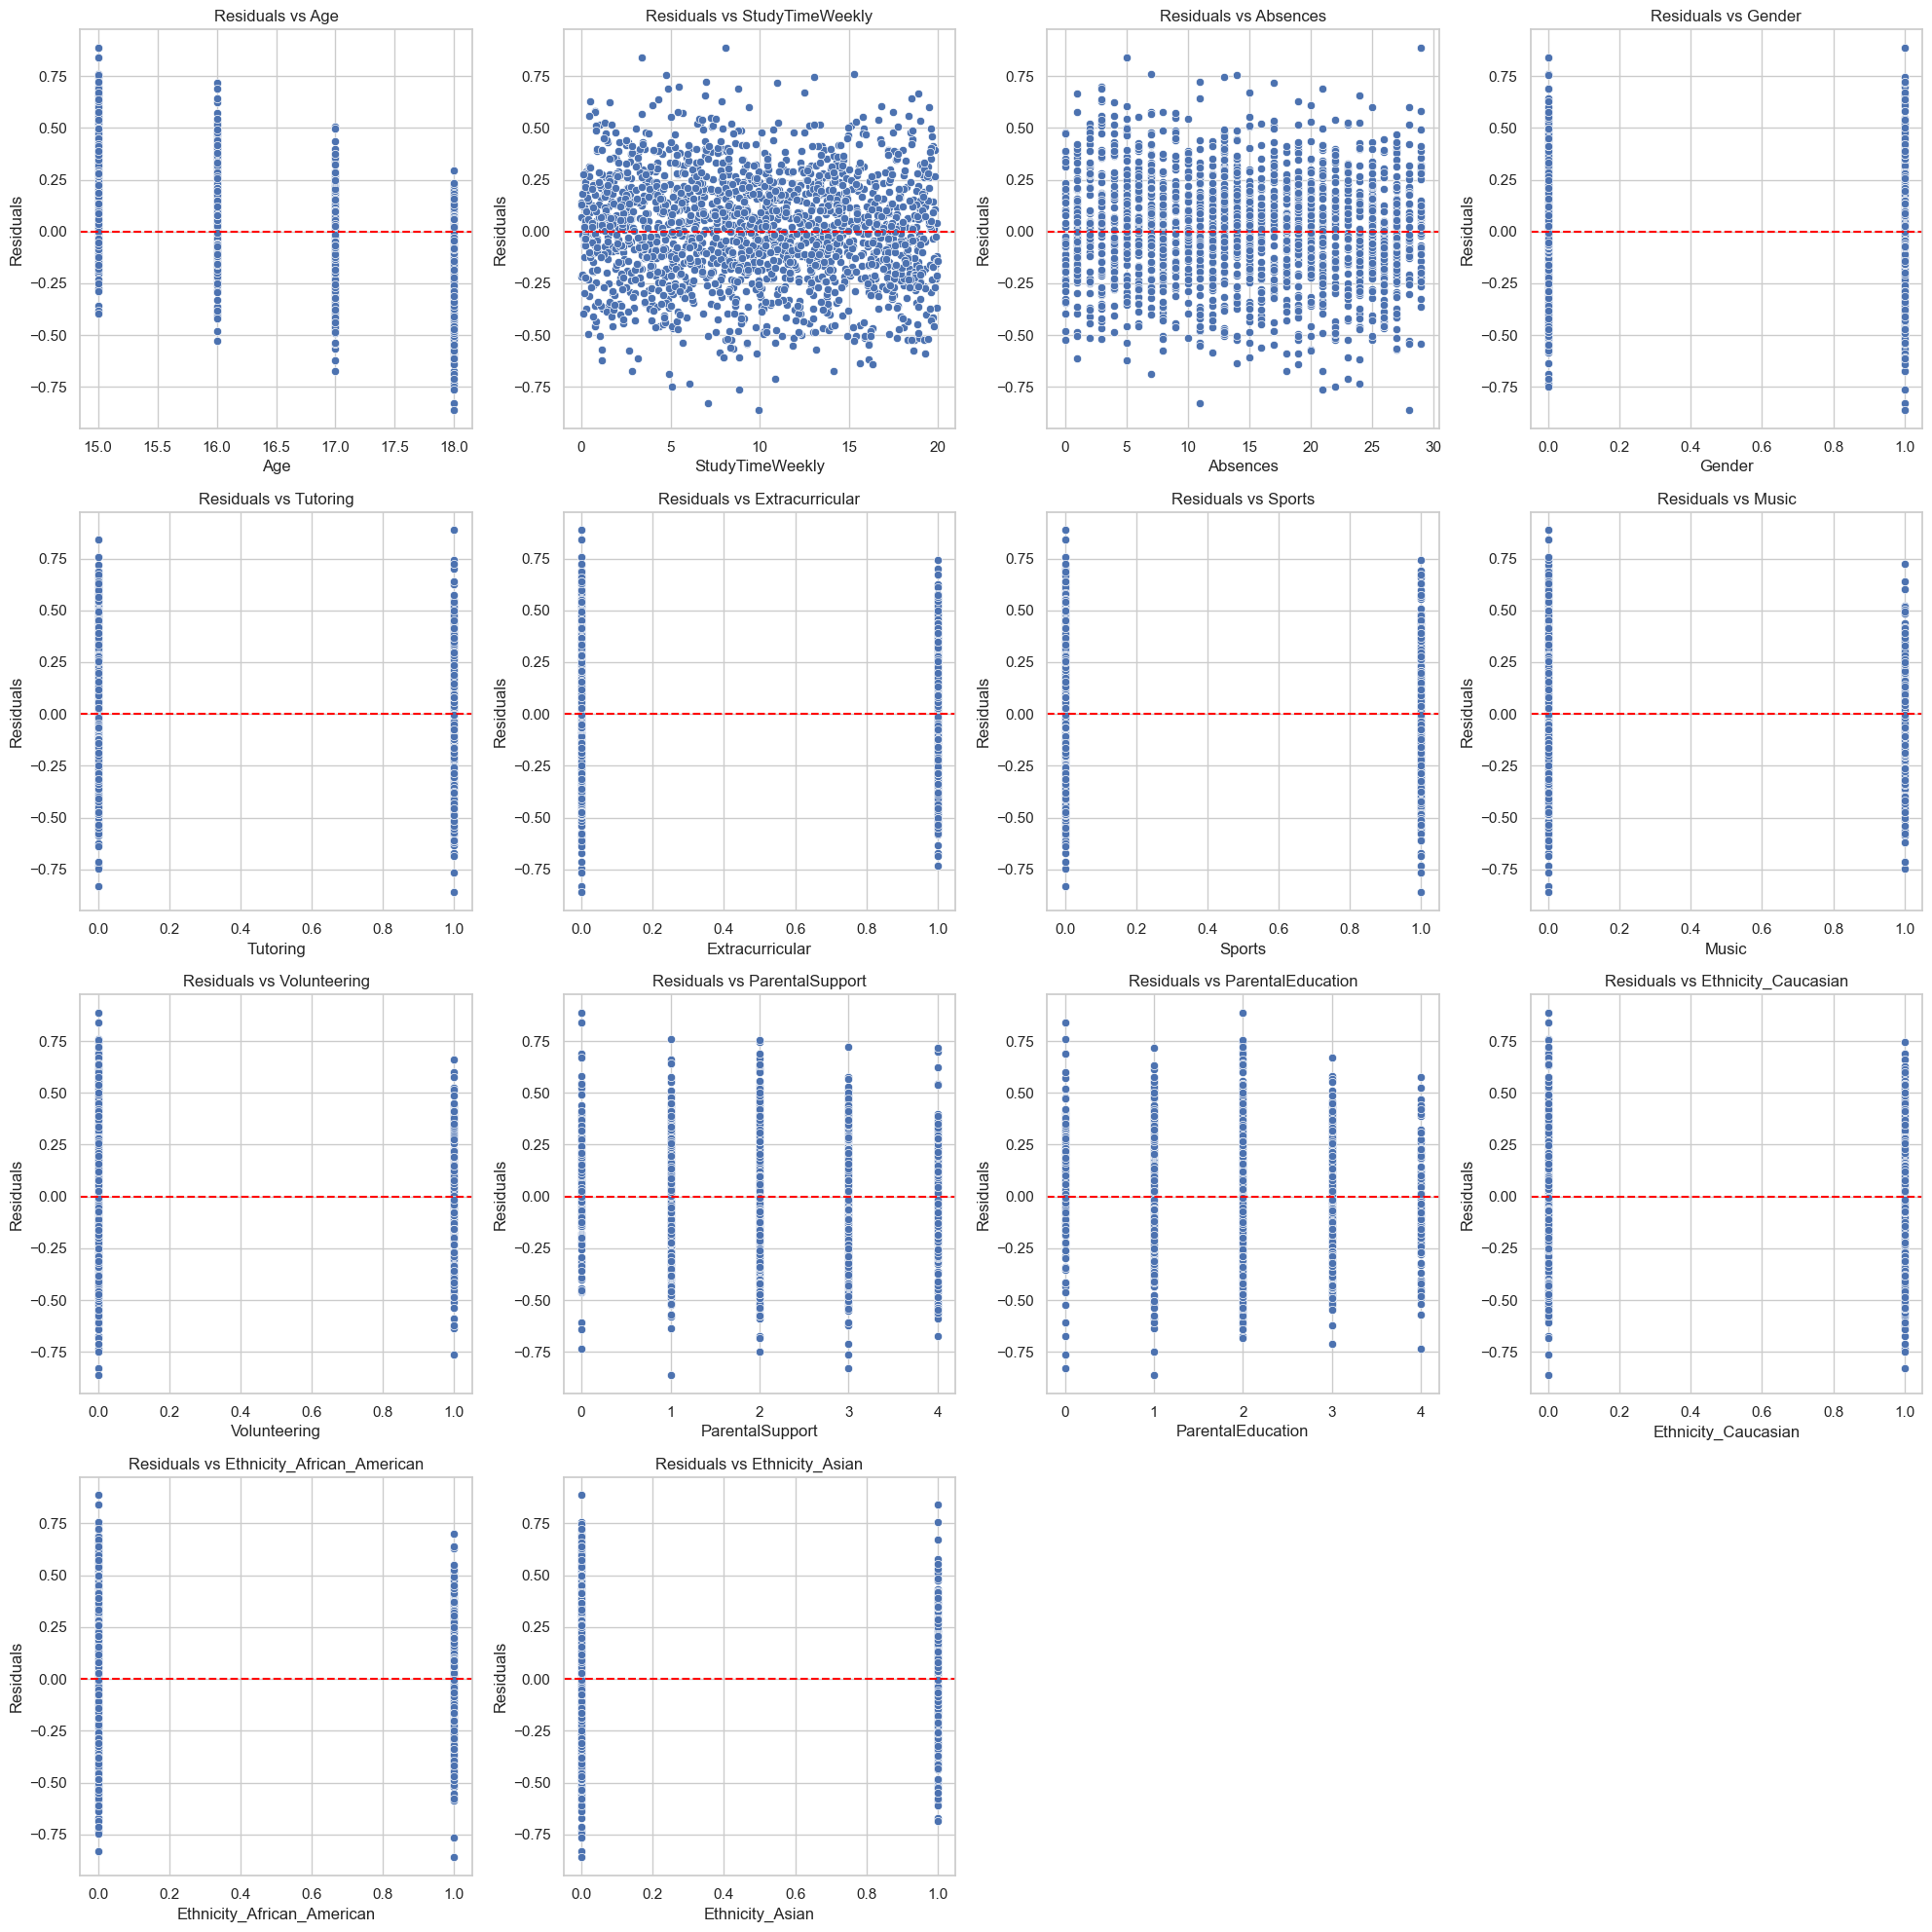

Durbin-Watson statistic: 1.9839240339846773


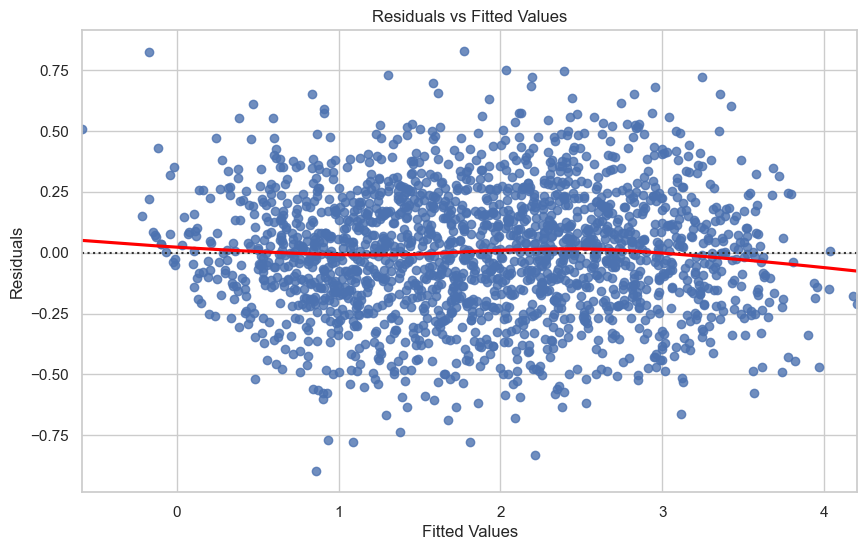

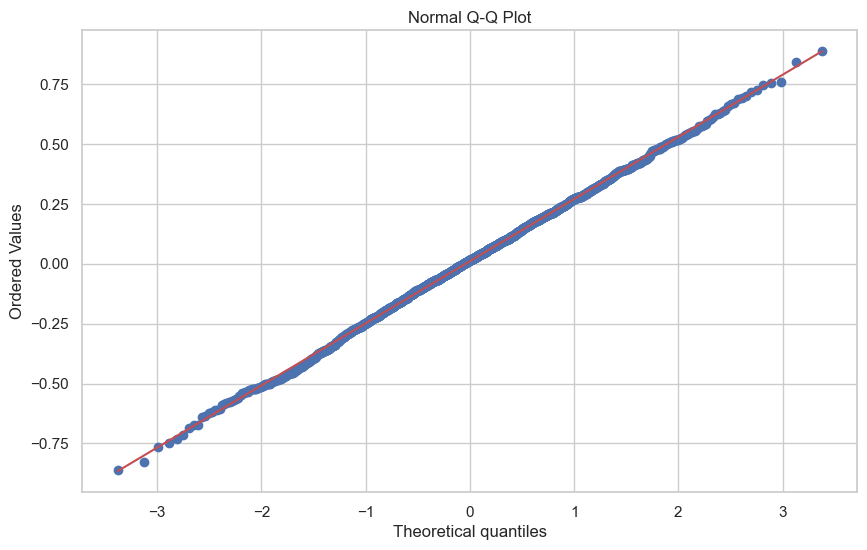

                       Feature         VIF
0                        const  237.901443
1                          Age    1.009062
2              StudyTimeWeekly    1.005312
3                     Absences    1.005702
4                       Gender    1.004526
5                     Tutoring    1.006342
6              Extracurricular    1.004190
7                       Sports    1.005267
8                        Music    1.004715
9                 Volunteering    1.004692
10             ParentalSupport    1.005793
11           ParentalEducation    1.006704
12         Ethnicity_Caucasian    3.211753
13  Ethnicity_African_American    2.573232
14             Ethnicity_Asian    2.519614


In [ ]:
# OLS Regression Assumptions

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ols, y_ols, test_size=0.2, random_state=42)

# Building the OLS model
ols_model_no_scaling = sm.OLS(y_train, X_train).fit()
print(ols_model_no_scaling.summary())

# Number of plots per row
plots_per_row = 4

# Checking OLS Assumptions

# 1. Linearity
# Scatter plots of residuals vs each independent variable
num_vars = len(X_train.columns)
n_rows = (num_vars + plots_per_row - 1) // plots_per_row  # Calculate rows needed
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 5 * n_rows))

for i, column in enumerate(X_train.columns):
    row, col = divmod(i, plots_per_row)
    sns.scatterplot(x=X_train[column], y=ols_model_no_scaling.resid, ax=axes[row, col])
    axes[row, col].axhline(y=0, color='red', linestyle='--')
    axes[row, col].set_title(f'Residuals vs {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Residuals')

# Remove empty subplots
for j in range(i + 1, n_rows * plots_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

# 2. Independence
# Checking for autocorrelation in residuals using the Durbin-Watson statistic
# Values close to 2 suggest no autocorrelation;
# values closer to 0 or 4 suggest positive or negative autocorrelation, respectively.
dw = sm.stats.stattools.durbin_watson(ols_model_no_scaling.resid)
print(f'Durbin-Watson statistic: {dw}')


# 3. Homoscedasticity
# Plotting residuals vs fitted values to check for homoscedasticity
# Homoscedasticity is characterized by a random scatter without any systematic pattern or funneling
plt.figure(figsize=(10, 6))
sns.residplot(x=ols_model_no_scaling.fittedvalues, y=ols_model_no_scaling.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 4. Normality of Residuals
# Q-Q plot to check the normality of residuals
# Residuals should approximately follow the straight line in the Q-Q plot to meet this assumption
plt.figure(figsize=(10, 6))
probplot(ols_model_no_scaling.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

# 5. No Perfect Multicollinearity
# Calculating VIFs to check for multicollinearity
# VIFs greater than 10 indicate a high multicollinearity issue
X_ols_with_const = sm.add_constant(X_ols)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_ols_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_ols_with_const.values, i) for i in range(X_ols_with_const.shape[1])]
print(vif_data)

In [ ]:
# OLS Regression (with and w/o scaling)
# Reminder:
# Numerical_vars = ['Age', 'StudyTimeWeekly', 'Absences']
# binary_vars = ['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

# Defining the independent variables and adding a constant to the model
X_ols = corrected_df[numerical_vars + binary_vars + ['ParentalSupport', 'ParentalEducation', 'Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian']]
y_ols = corrected_df['GPA']

# Split the data into training and testing sets before scaling and adding a constant
X_train, X_test, y_train, y_test = train_test_split(X_ols, y_ols, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Add a constant term to the independent variables before scaling
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the OLS model without standardization
ols_model_no_scaling = sm.OLS(y_train, X_train_const).fit()
print("OLS Model without Scaling")
print(ols_model_no_scaling.summary())

# Predict and evaluate without scaling
y_pred_no_scaling = ols_model_no_scaling.predict(X_test_const)
mse_no_scaling = mean_squared_error(y_test, y_pred_no_scaling)
r2_no_scaling = r2_score(y_test, y_pred_no_scaling)
print(f'Mean Squared Error (no scaling): {mse_no_scaling:.2f}')
print(f'R-squared (no scaling): {r2_no_scaling:.2f}')

# Fit the OLS model with scaling
ols_model_scaled = sm.OLS(y_train, X_train_scaled).fit()
print("OLS Model with Scaling")
print(ols_model_scaled.summary())

# Predict and evaluate with scaling
y_pred_scaled = ols_model_scaled.predict(X_test_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)
print(f'Mean Squared Error (scaled): {mse_scaled:.2f}')
print(f'R-squared (scaled): {r2_scaled:.2f}')

OLS Model without Scaling
                            OLS Regression Results                            
Dep. Variable:                    GPA   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     2821.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:57:04   Log-Likelihood:                 401.17
No. Observations:                1913   AIC:                            -772.3
Df Residuals:                    1898   BIC:                            -689.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

OLS Assumptions:
1. Linearity and Homoscedasticity - By looking at the Residuals vs. fitted plot - residual values are scattered randomly in a horizontal band around zero, indicating OLS requirement is satisfied.
2. Normality - Looking at the Q-Q plot of the residuals, points lie on the 45-degree line, meeting OLS requirement.
3. Multicollinearity - VIF values. VIF values are smaller than 10, indicating no sign to multicollinearity.
4. Durbin-Watson Statistic for Independence - Equals 2.00, indicating no autocorrelation.  

OLS assumptions are met, and R-squared=0.954 and p-value=0.00 for both w/o and w/ scaling, meaning the OLS is excellent fit.

In [ ]:
''' Defining a new dataframe with grouped variables for 'StudyTimeWeekly', 'Absences', and 'Age', and
re-run OLS using scaling, to check for bias resulting from variable range'''

# Creating a copy of the corrected_df to adjusted_df
adjusted_df = corrected_df.copy()

# Defining the 'Absences_Level' variable
adjusted_df['Absences_Level'] = pd.cut(adjusted_df['Absences'], bins=[-1, 5, 14, 30], labels=[0, 1, 2])

# Defining the 'StudyTime_Levels' variable
adjusted_df['StudyTime_Levels'] = pd.cut(adjusted_df['StudyTimeWeekly'], bins=[-1, 7, 14, 21], labels=[0, 1, 2])

# Defining the 'Age_Level' variable
adjusted_df['Age_Level'] = pd.cut(adjusted_df['Age'], bins=[14, 16, 17, 19], labels=[0, 1, 2])

# Checking the resulting dataframe
print(adjusted_df.head())

   Age  Gender  ParentalEducation  StudyTimeWeekly  Absences  Tutoring  \
0   17       1                  2        19.833723         7         1   
1   18       0                  1        15.408756         0         0   
2   15       0                  3         4.210570        26         0   
3   17       1                  3        10.028829        14         0   
4   17       1                  2         4.672495        17         1   

   ParentalSupport  Extracurricular  Sports  Music  Volunteering       GPA  \
0                2                0       0      1             0  2.929196   
1                1                0       0      0             0  3.042915   
2                2                0       0      0             0  0.112602   
3                3                1       0      0             0  2.054218   
4                3                0       0      0             0  1.288061   

   GradeClass  Ethnicity_Caucasian  Ethnicity_African_American  \
0         2.0       

In [ ]:
# Excluding original continuous variables and including new categorical levels
adjusted_df = corrected_df.copy()

# Defining the 'Absences_Level' variable
adjusted_df['Absences_Level'] = pd.cut(adjusted_df['Absences'], bins=[-1, 5, 14, 30], labels=[0, 1, 2])

# Defining the 'StudyTime_Levels' variable
adjusted_df['StudyTime_Levels'] = pd.cut(adjusted_df['StudyTimeWeekly'], bins=[-1, 7, 14, 21], labels=[0, 1, 2])

# Defining the 'Age_Level' variable
adjusted_df['Age_Level'] = pd.cut(adjusted_df['Age'], bins=[14, 16, 17, 19], labels=[0, 1, 2])

# Exclude original continuous variables and include new categorical levels
variables_to_exclude = ['Age', 'StudyTimeWeekly', 'Absences']
variables_to_include = [var for var in corrected_df.columns if var not in variables_to_exclude]
variables_to_include += ['Absences_Level', 'StudyTime_Levels', 'Age_Level']

# Preparing the dataset for OLS
X_adjusted = adjusted_df[variables_to_include]
X_adjusted = X_adjusted.drop(columns=['GPA', 'GradeClass'])  # Ensuring GPA and GradeClass are not in the predictors
y_adjusted = adjusted_df['GPA']

# Splitting the data into training and testing sets
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X_adjusted, y_adjusted, test_size=0.2, random_state=42)

# Standardizing the data (excluding the constant term)
scaler = StandardScaler()
X_train_scaled_adjusted = scaler.fit_transform(X_train_adjusted)
X_test_scaled_adjusted = scaler.transform(X_test_adjusted)

# Creating DataFrame with original column names after scaling
X_train_scaled_adjusted = pd.DataFrame(X_train_scaled_adjusted, columns=X_train_adjusted.columns, index=X_train_adjusted.index)
X_test_scaled_adjusted = pd.DataFrame(X_test_scaled_adjusted, columns=X_test_adjusted.columns, index=X_test_adjusted.index)

# Adding the constant back after scaling
X_train_scaled_adjusted = sm.add_constant(X_train_scaled_adjusted, has_constant='add')
X_test_scaled_adjusted = sm.add_constant(X_test_scaled_adjusted, has_constant='add')

# Fitting the OLS model with scaling
ols_model_scaled_adjusted = sm.OLS(y_train_adjusted, X_train_scaled_adjusted).fit()
print("OLS Model with Scaling (Adjusted)")
print(ols_model_scaled_adjusted.summary())

# Predicting and evaluating with scaling
y_pred_scaled_adjusted = ols_model_scaled_adjusted.predict(X_test_scaled_adjusted)
mse_scaled_adjusted = mean_squared_error(y_test_adjusted, y_pred_scaled_adjusted)
r2_scaled_adjusted = r2_score(y_test_adjusted, y_pred_scaled_adjusted)
print(f'Mean Squared Error (scaled, adjusted): {mse_scaled_adjusted:.2f}')
print(f'R-squared (scaled, adjusted): {r2_scaled_adjusted:.2f}')

OLS Model with Scaling (Adjusted)
                            OLS Regression Results                            
Dep. Variable:                    GPA   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     548.3
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:57:04   Log-Likelihood:                -999.29
No. Observations:                1913   AIC:                             2029.
Df Residuals:                    1898   BIC:                             2112.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [ ]:
# VIF Analysis of numerical variables (adjusted_df)
# Calculating VIF for each independent variable
adjusted_df = adjusted_df.drop(columns=['Age', 'Absences', 'StudyTimeWeekly'])
X_vif = adjusted_df.drop(columns=['GPA'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

                       Feature        VIF
0                       Gender   1.987819
1            ParentalEducation   3.671775
2                     Tutoring   1.422782
3              ParentalSupport   3.930239
4              Extracurricular   1.591764
5                       Sports   1.424478
6                        Music   1.246361
7                 Volunteering   1.186025
8                   GradeClass  13.151471
9          Ethnicity_Caucasian   4.640319
10  Ethnicity_African_American   2.453229
11             Ethnicity_Asian   2.416583
12              Absences_Level   8.827375
13            StudyTime_Levels   2.226108
14                   Age_Level   1.766175


In [ ]:
# OLS Regression for selected variables, with beta >=0.05 in the scaled OLS model
# Selecting the independent variables and the target variable
X_mult_reg = corrected_df[['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music']]
y_mult_reg = corrected_df['GPA']  # target

# Adding a constant term to the independent variables
X_mult_reg = sm.add_constant(X_mult_reg)

# Standardizing the data (excluding the constant term)
scaler = StandardScaler()
X_mult_reg_scaled = scaler.fit_transform(X_mult_reg.drop(columns=['const']))
X_mult_reg_scaled = pd.DataFrame(X_mult_reg_scaled, columns=X_mult_reg.columns.drop('const'))

# Adding the constant term back to the scaled data
X_mult_reg_scaled = sm.add_constant(X_mult_reg_scaled)

# Fitting the multiple regression model with scaled data
multiple_regression_model_scaled = sm.OLS(y_mult_reg, X_mult_reg_scaled).fit()

# Printing the summary of the multiple regression model
print(multiple_regression_model_scaled.summary())

# Predicting the target variable
y_pred = multiple_regression_model_scaled.predict(X_mult_reg_scaled)

# Calculating and print the Mean Squared Error (MSE)
mse = mean_squared_error(y_mult_reg, y_pred)
print(f'Mean Squared Error (scaled): {mse:.2f}')

                            OLS Regression Results                            
Dep. Variable:                    GPA   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     7052.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:57:04   Log-Likelihood:                 499.37
No. Observations:                2392   AIC:                            -982.7
Df Residuals:                    2384   BIC:                            -936.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9062      0.004    4

power of the test - the probability of correctly rejecting the null hypothesis when it is false

Estimated power of the test: 1.0


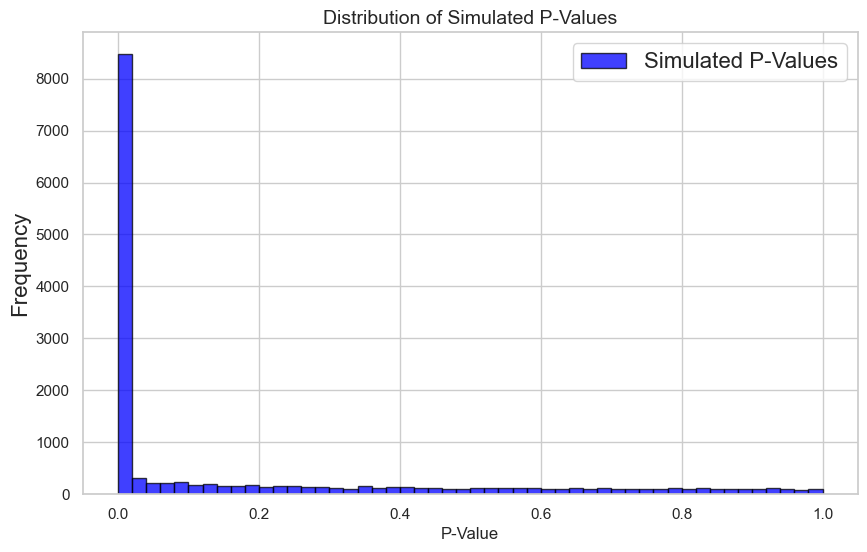

In [ ]:
# Conducting a Simulation for Power Analysis, as a way to estimate Type II Error
# Define the number of simulations
# Number of simulations
n_simulations = 1000
significant_count = 0

# Extracting coefficients and standard errors from the scaled model
params = ols_model_scaled.params
st_err = ols_model_scaled.bse

# Array for storing p-values from each simulation
p_values = []

# Simulation loop
for _ in range(n_simulations):
    # Generate simulated coefficients based on the normal distribution
    simulated_betas = np.random.normal(params, st_err)

    # Calculating t-values for each coefficient
    t_values = simulated_betas / st_err

    # Calculating two-tailed p-values for each coefficient
    sim_p_values = 2 * (1 - stats.norm.cdf(np.abs(t_values)))

    # Appending each simulation's p-values to the list
    p_values.extend(sim_p_values)

    # Check if any of the p-values are less than 0.05 (rejecting the null hypothesis)
    if (sim_p_values < 0.05).any():
        significant_count += 1

# Calculating the power of the test (proportion of simulations where the null hypothesis was rejected)
power = significant_count / n_simulations
print("Estimated power of the test:", power)

# Plotting the histogram of p-values
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=50, color='blue', edgecolor='black', alpha=0.75, label='Simulated P-Values')
plt.xlabel('P-Value')
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Simulated P-Values', fontsize=14)
plt.legend(prop={'size': 16})
plt.show()

Most p-values are concentrated in low values, near zero, indicating high confidence in the model and very probability of Type II error.

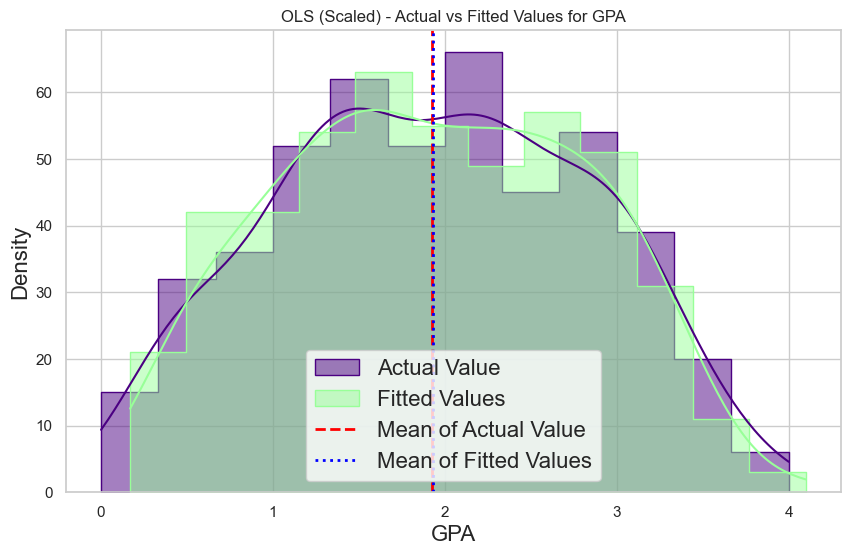

In [ ]:
# Plotting actual vs fitted values for OLS model with scaling
plt.figure(figsize=(10, 6))

# Plotting histograms with KDE
ax1 = sns.histplot(y_test, kde=True, color="#4B0082", label="Actual Value", element='step')
sns.histplot(y_pred_scaled, kde=True, color="#98FF98", label="Fitted Values", ax=ax1, element='step')

# Adding vertical lines for means
mean_y_test = y_test.mean()
plt.axvline(mean_y_test, color='#FF0000', linestyle='--', linewidth=2, label='Mean of Actual Value')

mean_y_pred_scaled = y_pred_scaled.mean()
plt.axvline(mean_y_pred_scaled, color='#0000FF', linestyle=':', linewidth=2, label='Mean of Fitted Values')

plt.title('OLS (Scaled) - Actual vs Fitted Values for GPA')
plt.xlabel('GPA', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=16)
plt.show()
plt.close()

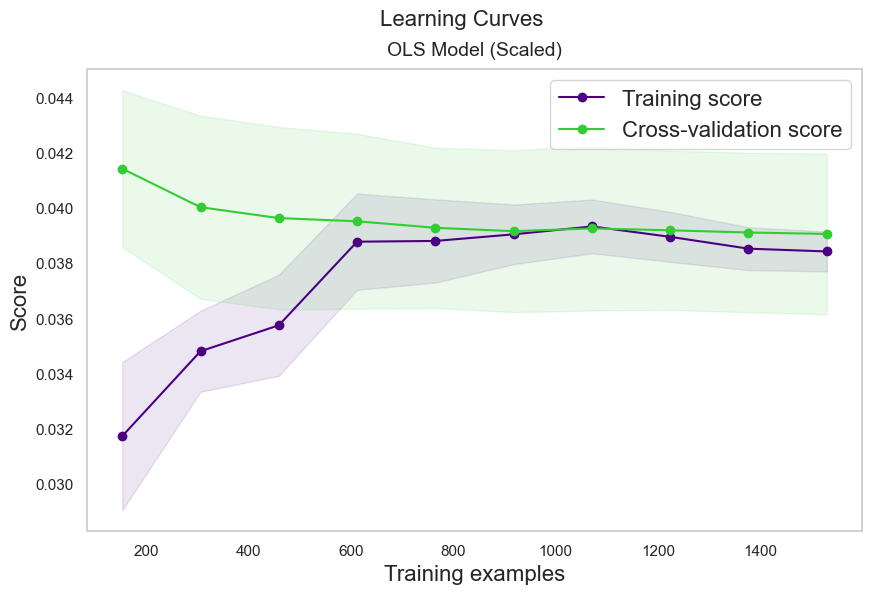

In [ ]:
# Plotting the learning curve for the OLS model (scaled)
# Defining the function to plot learning curves
def plot_learning_curve(estimator, X, y, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.suptitle("Learning Curves", fontsize=16)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize=16)
    plt.ylabel("Score", fontsize=16)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#4B0082")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#32CD32")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#4B0082", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#32CD32", label="Cross-validation score")

    plt.legend(loc="best", fontsize=16)
    plt.title('OLS Model (Scaled)', loc='center', fontsize=14, pad=10)
    plt.show()

# Using the same scaling and data preparation as the scaled OLS model
X_ols = corrected_df[numerical_vars + binary_vars + ['ParentalSupport', 'ParentalEducation', 'Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian']]
y_ols = corrected_df['GPA']

# Splitting the data into training and testing sets before scaling
X_train, X_test, y_train, y_test = train_test_split(X_ols, y_ols, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adding a constant after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Defining the linear regression model
linear_regression_model = LinearRegression()

# Plotting the learning curve using the scaled dataset
plot_learning_curve(linear_regression_model, X_train_scaled, y_train, cv=5, n_jobs=-1)

The learning curve indicates that the OLS model is performing well. The training and cross-validation scores converge and stabilize, indicating good generalization. The model is neither overfitting nor underfitting, suggesting this is a reliable model.  

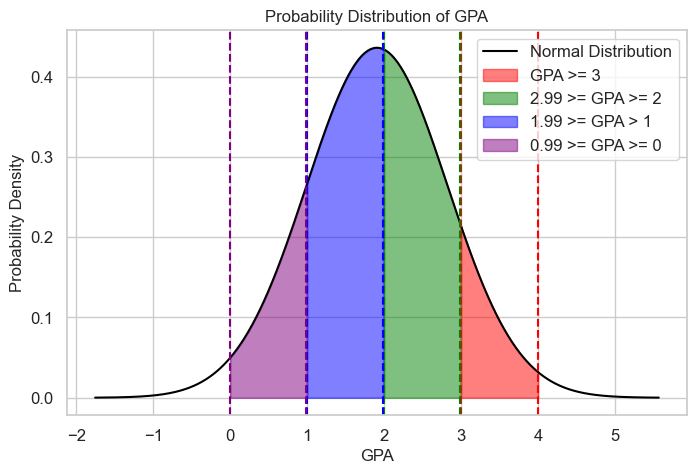

In [ ]:
# A general GPA probablity distribution, by GPA groups
# Assuming GPA follows an approximate normal distribution
mean_gpa = corrected_df['GPA'].mean()
std_gpa = corrected_df['GPA'].std()

# GPA ranges to highlight
gpa_ranges = [
    (3, 4, 'GPA >= 3', 'red'),
    (2, 2.99, '2.99 >= GPA >= 2', 'green'),
    (1, 1.99, '1.99 >= GPA > 1', 'blue'),
    (0, 0.99, '0.99 >= GPA >= 0', 'purple')
]

# Plotting the normal distribution curve
fig, ax = plt.subplots(figsize=(8, 5))
x = np.linspace(mean_gpa - 4 * std_gpa, mean_gpa + 4 * std_gpa, 1000)
ax.plot(x, norm.pdf(x, mean_gpa, std_gpa), label='Normal Distribution', color='black')

# Highlighting the areas for the specified GPA ranges
for gpa_min, gpa_max, label, color in gpa_ranges:
    x_high = np.linspace(gpa_min, gpa_max, 1000)
    ax.fill_between(x_high, norm.pdf(x_high, mean_gpa, std_gpa), color=color, alpha=0.5, label=label)
    ax.axvline(x=gpa_min, color=color, linestyle='--')
    ax.axvline(x=gpa_max, color=color, linestyle='--')

# Customizing plot aesthetics
ax.set_title('Probability Distribution of GPA', fontsize=12)
ax.set_xlabel('GPA', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)

plt.show()

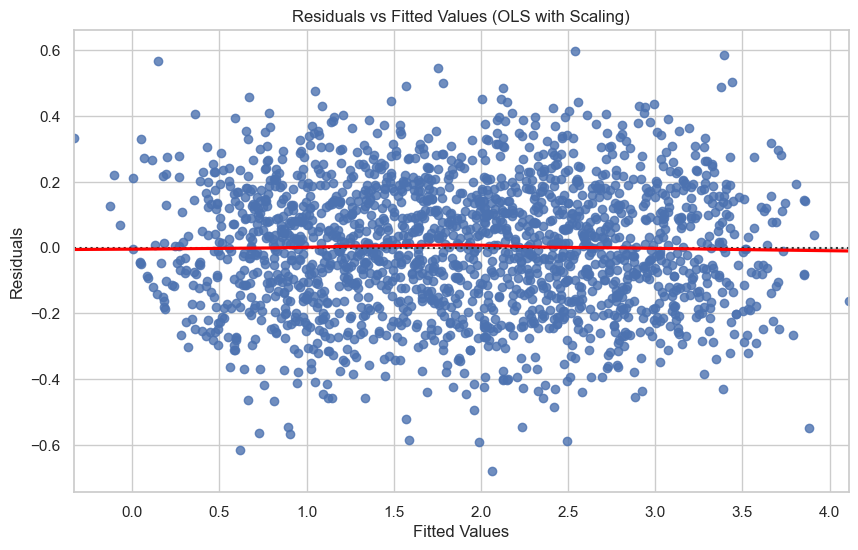

In [ ]:
# Residual plot for OLS with scaling
plt.figure(figsize=(10, 6))
sns.residplot(x=ols_model_scaled.fittedvalues, y=ols_model_scaled.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values (OLS with Scaling)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 5. Feature Importance

C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\3423379466.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=coefficients_scaled.values, y=coefficients_scaled.index, palette=colors)
C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\3423379466.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bars.set_yticklabels(bars.get_yticklabels(), fontsize=14)


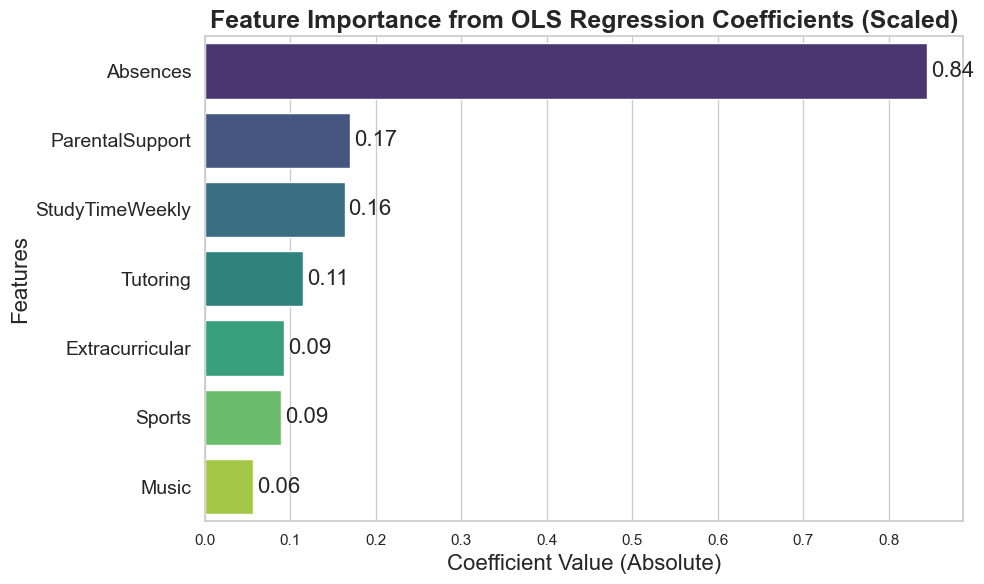

In [ ]:
# Feature Importance
# Setting the variables
X_scaled_model = corrected_df[['StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music']]
y_scaled_model = corrected_df['GPA']

# Standardizing predictors
scaler = StandardScaler()
X_scaled_model_scaled = scaler.fit_transform(X_scaled_model)
X_scaled_model_scaled = pd.DataFrame(X_scaled_model_scaled, columns=X_scaled_model.columns)

# Adding a constant to the predictors
X_scaled_model_scaled = sm.add_constant(X_scaled_model_scaled)

# Fitting the OLS regression model (scaled)
model_scaled = sm.OLS(y_scaled_model, X_scaled_model_scaled).fit()

# Getting coefficients (excluding the constant term)
coefficients_scaled = model_scaled.params.drop('const')
coefficients_scaled = coefficients_scaled.abs().sort_values(ascending=False)

# Defining custom colors
colors = sns.color_palette('viridis', len(coefficients_scaled))

# Plotting feature importance
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=coefficients_scaled.values, y=coefficients_scaled.index, palette=colors)
plt.title('Feature Importance from OLS Regression Coefficients (Scaled)', fontsize=18, fontweight='bold')
plt.xlabel('Coefficient Value (Absolute)', fontsize=16)
plt.ylabel('Features', fontsize=16)

# Adjusting the font size of the y-axis labels
bars.set_yticklabels(bars.get_yticklabels(), fontsize=14)

# Adding text annotations
for bar, value in zip(bars.patches, coefficients_scaled.values):
    plt.text(bar.get_width() + 0.03, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.show()

Feature Importance is highest for 'Absences', which is in line with the correlation matrix heatmap. Additional Importance features are ParentalSupport and StudyTimeWeekly, and Tutoring.

C:\Users\chuch\AppData\Local\Temp\ipykernel_7160\1761197378.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=coefficients_adjusted_fi.values, y=coefficients_adjusted_fi.index, palette=colors)


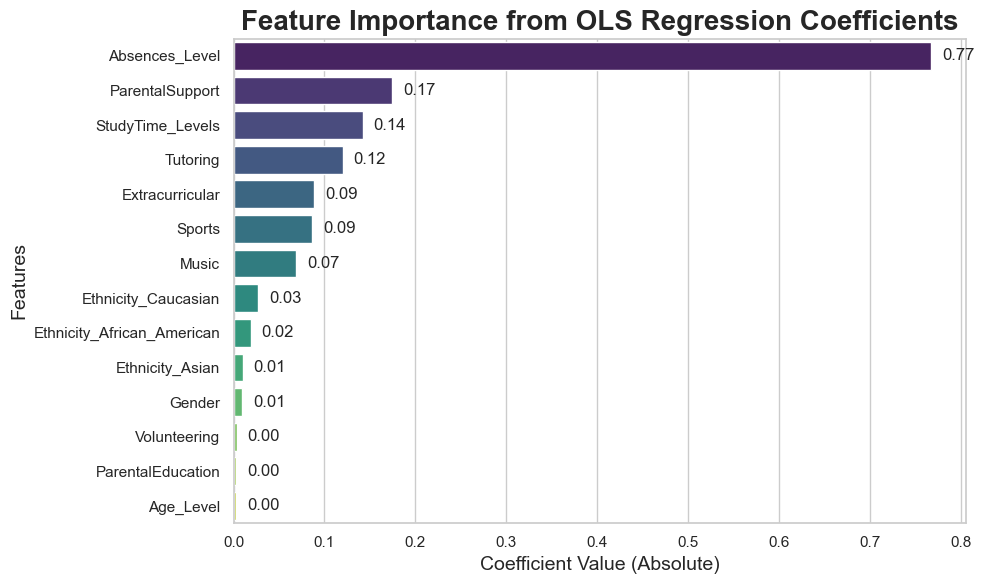

In [ ]:
# Feature Importance with Adjusted DataFrame
# Defining the independent variables and dependent variable for the OLS analysis
X_adjusted_fi = adjusted_df.drop(columns=['GPA', 'GradeClass'])
y_adjusted_fi = corrected_df['GPA']  # Using the original 'GPA' as the dependent variable

# Standardizing predictors
scaler_adjusted_fi = StandardScaler()
X_adjusted_scaled_fi = scaler_adjusted_fi.fit_transform(X_adjusted_fi)
X_adjusted_scaled_fi = pd.DataFrame(X_adjusted_scaled_fi, columns=X_adjusted_fi.columns)

# Adding a constant to the predictors
X_adjusted_scaled_fi = sm.add_constant(X_adjusted_scaled_fi)

# Fitting the OLS regression model
model_adjusted_fi = sm.OLS(y_adjusted_fi, X_adjusted_scaled_fi).fit()

# Getting coefficients
coefficients_adjusted_fi = model_adjusted_fi.params.drop('const')
coefficients_adjusted_fi = coefficients_adjusted_fi.abs().sort_values(ascending=False)

# Defining custom colors
colors = sns.color_palette('viridis', len(coefficients_adjusted_fi))

# Plotting feature importance
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=coefficients_adjusted_fi.values, y=coefficients_adjusted_fi.index, palette=colors)
plt.title('Feature Importance from OLS Regression Coefficients', fontsize=20, fontweight='bold')
plt.xlabel('Coefficient Value (Absolute)', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Adding text annotations
for bar, value in zip(bars.patches, coefficients_adjusted_fi.values):
    plt.text(bar.get_width() + 0.03, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', ha='center', va='center')

plt.tight_layout()
plt.show()

Even after eliminating the theoretical effect of variables with a relatively wide range of values (by narrowing the value range of variables by grouping values in new variables in the adjust_df_fi dataframe) feature importance remains the same, indicating these are indeed the most significant predictors in this dataset.

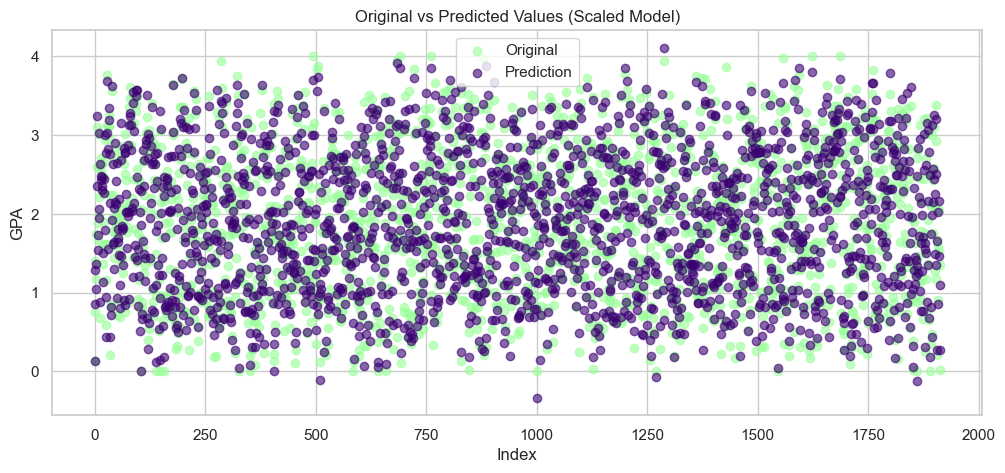

In [ ]:
# Original vs predicted values
#  Using the scaled OLS model for prediction
prediction_scaled = ols_model_scaled.predict(X_train_scaled)

# Plotting
plt.figure(figsize=(12, 5))
plt.scatter(range(len(y_train)), y_train, color='#98FF98', label='Original', alpha=0.6)
plt.scatter(range(len(prediction_scaled)), prediction_scaled, color='#3B0072', label='Prediction', alpha=0.6)

plt.title('Original vs Predicted Values (Scaled Model)')
plt.xlabel('Index')
plt.ylabel('GPA')
plt.legend()
plt.show()
plt.show()

Overlapping values all over the plot indicate excellent fit of the model with original values.

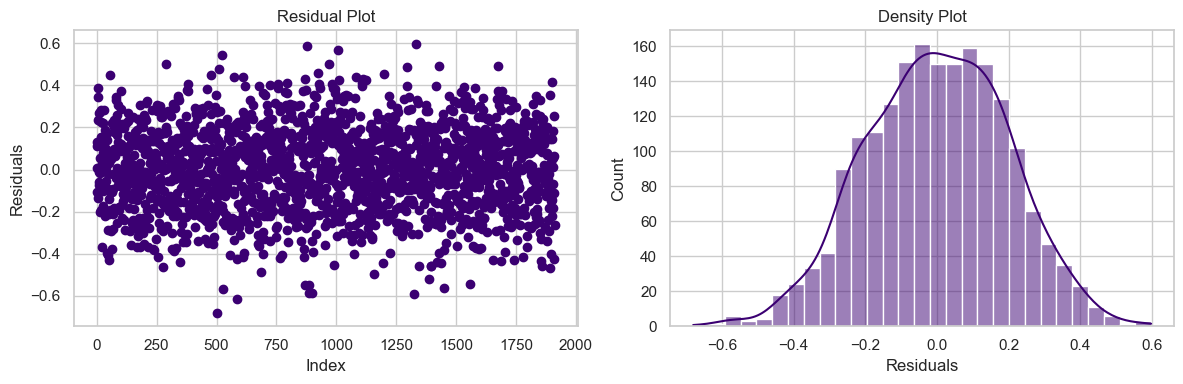

In [ ]:
# Analysis of residuals for the OLS scaled model
# Calculating residuals from the scaled model
residuals_scaled = ols_model_scaled.resid

# Creating subplots for residual plot and density plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the residuals
ax[0].scatter(range(len(residuals_scaled)), residuals_scaled, color='#3B0072')
ax[0].set_title('Residual Plot')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Residuals')

# Plotting the density of the residuals
sns.histplot(residuals_scaled, kde=True, ax=ax[1], color='#3B0072')
ax[1].set_title('Density Plot')
ax[1].set_xlabel('Residuals')

plt.tight_layout()
plt.show()

Residual Density plot is displaying normal distribution, and values are scattered around zero.

# 6. 'GradeClass' as categorical 'GPA'

Since 'GradeClass' is derived from 'GPA' values and is a categorical variable, we can use it for additional statistical tests, that are appropriate for a categorical variable.

In [ ]:
# Generating a new dataframe for analysis of 'GradeClass' which is the categorical version of 'GPA'
# Removing 'GPA' from the dataframe dedicated to analyzing 'GradeClass'
GradeClass_df = corrected_df.drop(columns=['GPA'])

In [ ]:
# Basic analysis of 'GradeClass'
# Check the distribution of 'GradeClass'
print(GradeClass_df['GradeClass'].value_counts())

# Descriptive Analysis
print(GradeClass_df.groupby('GradeClass').mean())


GradeClass
4.0    1211
3.0     414
2.0     391
1.0     269
0.0     107
Name: count, dtype: int64
                  Age    Gender  ParentalEducation  StudyTimeWeekly  \
GradeClass                                                            
0.0         16.476636  0.457944           1.700935        11.854926   
1.0         16.460967  0.509294           1.698885        11.122335   
2.0         16.508951  0.496164           1.662404        10.106404   
3.0         16.449275  0.514493           1.751208         9.757963   
4.0         16.463254  0.519405           1.786127         9.184822   

             Absences  Tutoring  ParentalSupport  Extracurricular    Sports  \
GradeClass                                                                    
0.0          5.747664  0.485981         2.682243         0.514019  0.355140   
1.0          5.312268  0.405204         2.382900         0.420074  0.342007   
2.0          7.250639  0.301790         2.104859         0.414322  0.281330   
3.0       

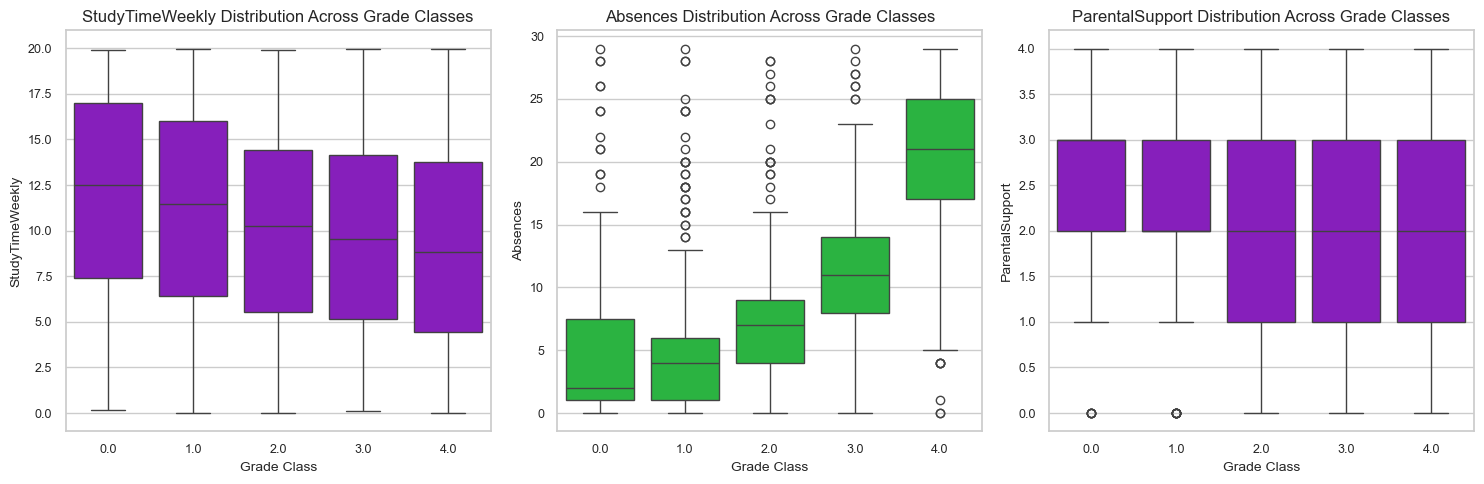

In [ ]:
# Visualization
# Box plots of selected features by GradeClass
# Define custom colors
colors = ['#8e05d5', '#15c932']  # Deep Purple and Lime Green

# List of numerical features to plot
numerical_features_gradeclass = ['StudyTimeWeekly', 'Absences', 'ParentalSupport']

# Defining the number of columns per row
n_cols = 3  # Three columns per row
n_rows = (len(numerical_features_gradeclass) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Plotting box plots for each feature
for i, feature in enumerate(numerical_features_gradeclass):
    sns.boxplot(x='GradeClass', y=feature, data=GradeClass_df, ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(f'{feature} Distribution Across Grade Classes', fontsize=12)  # Adjust title font size
    axes[i].set_xlabel('Grade Class', fontsize=10)  # Adjust x-axis label font size
    axes[i].set_ylabel(feature, fontsize=10)  # Adjust y-axis label font size
    axes[i].tick_params(axis='both', which='major', labelsize=9)  # Adjust tick label font size

# Removing any unused subplots
for j in range(len(numerical_features_gradeclass), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

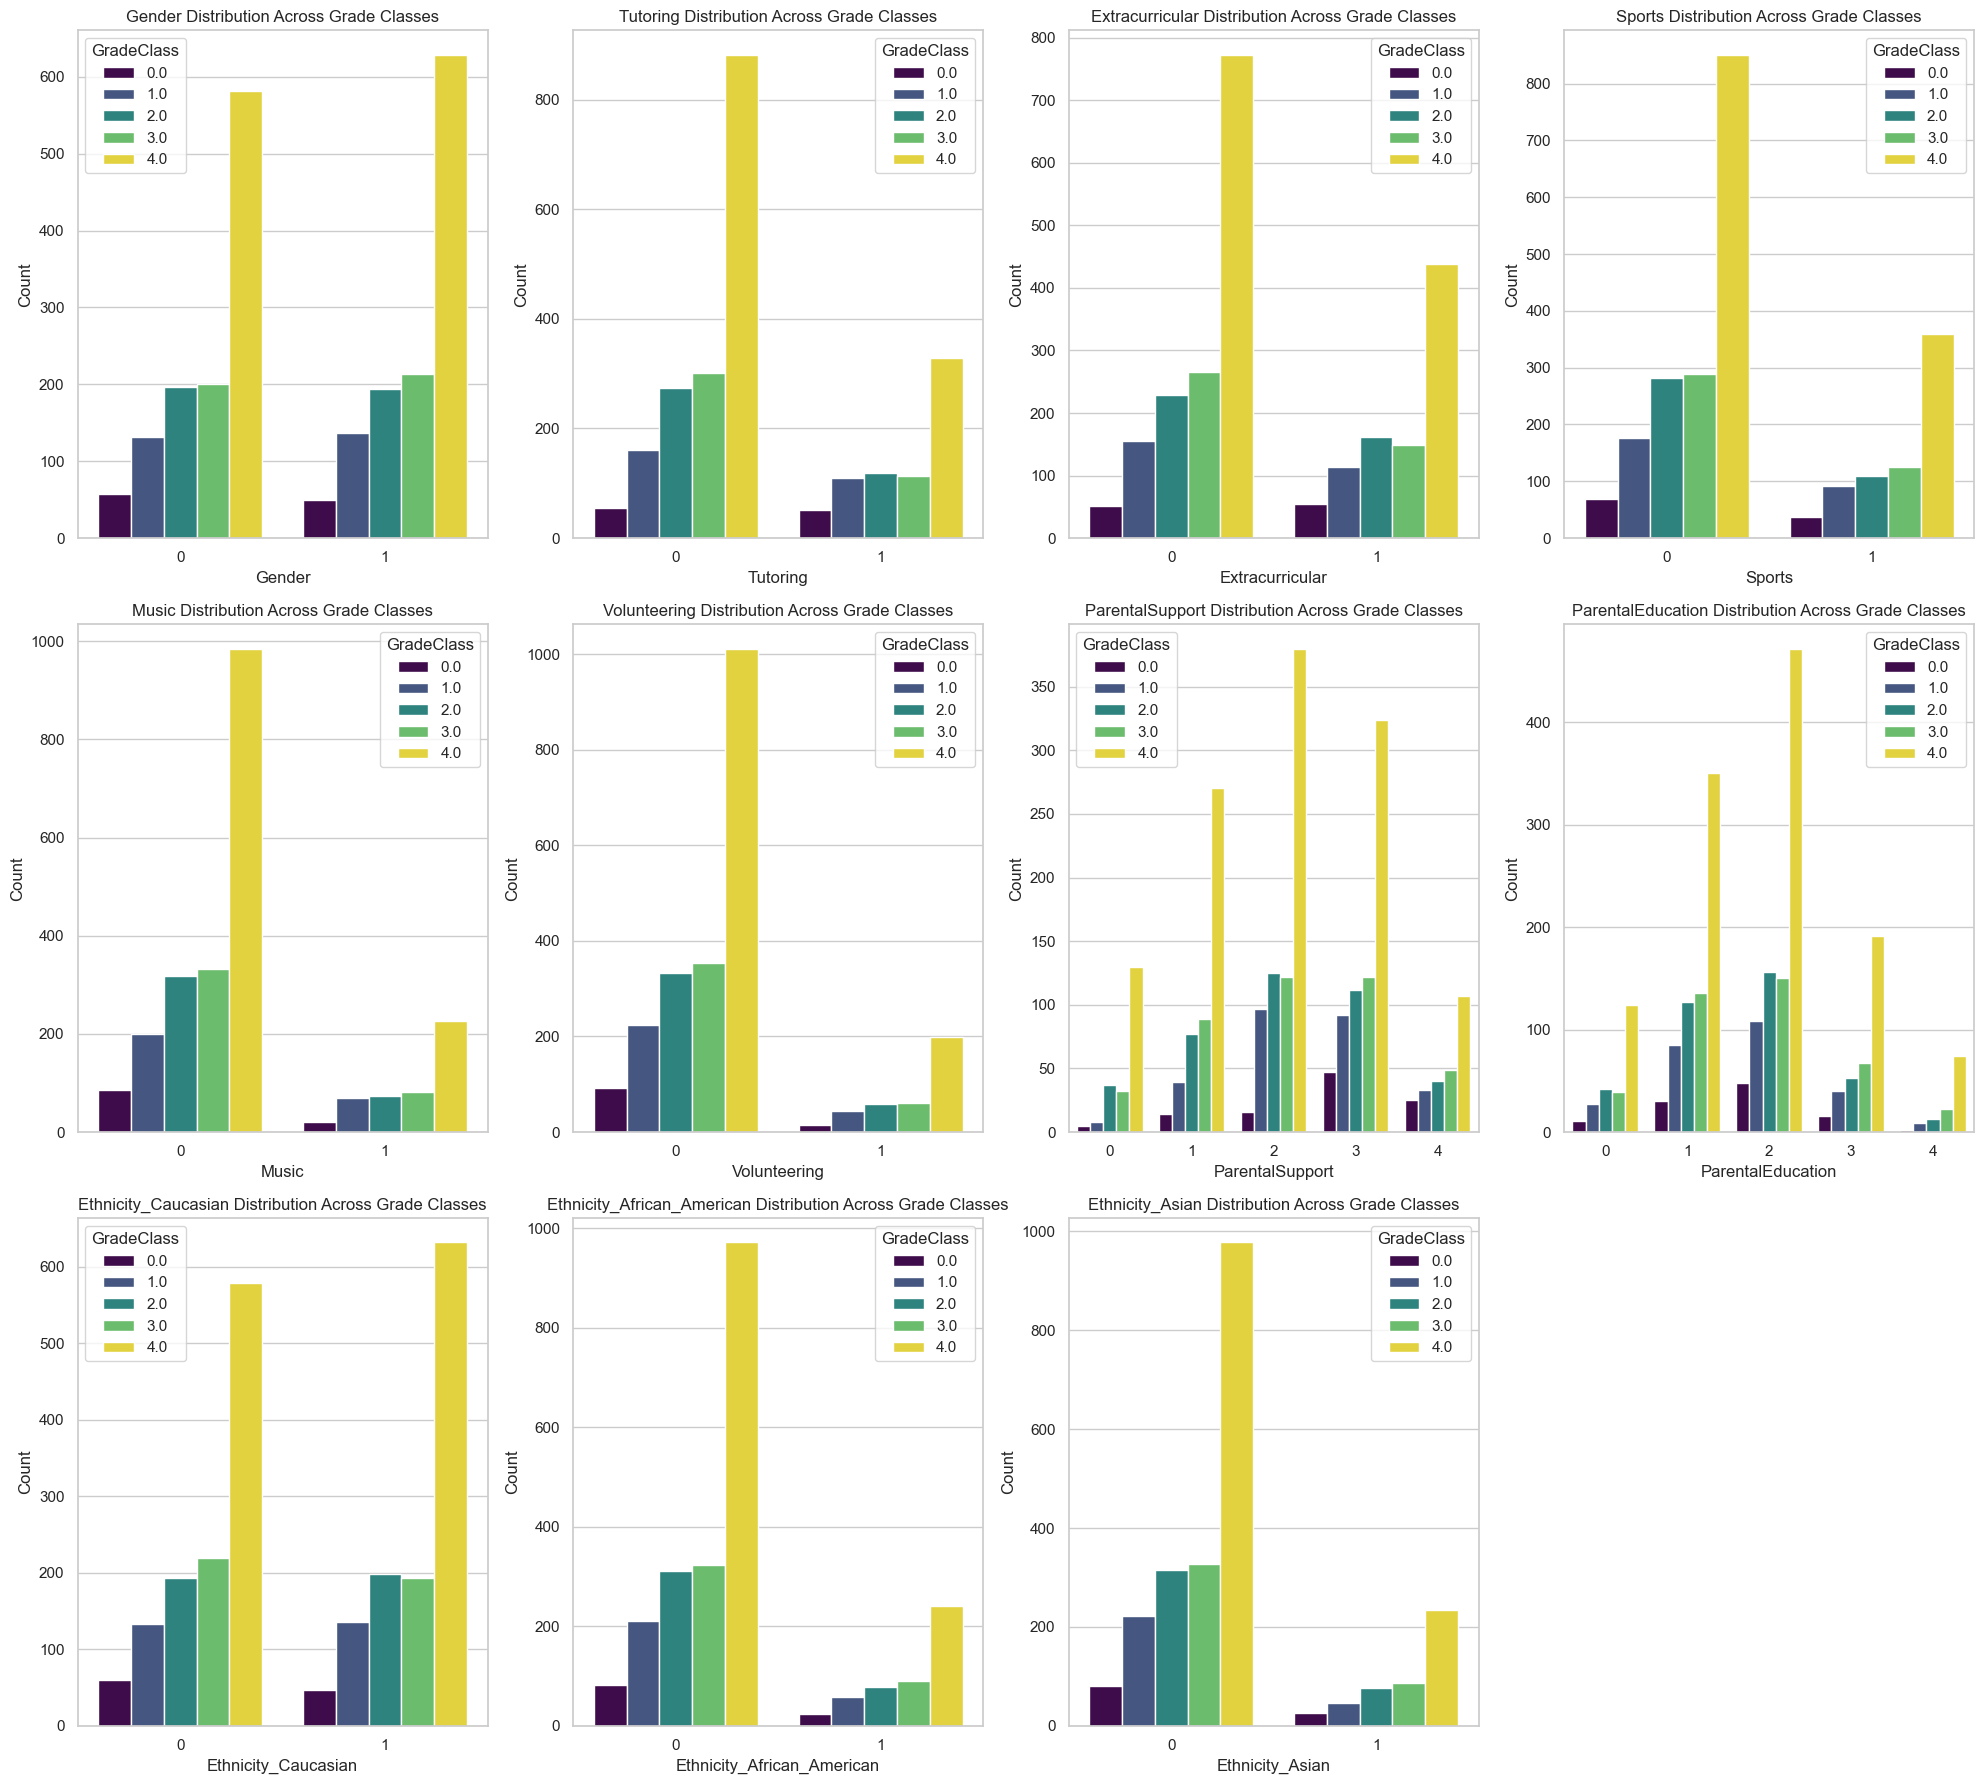

In [ ]:
# Bar plots for categorical variables by GradeClass
# List of categorical features to plot
categorical_features_gradeclass = ['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering',
                                   'ParentalSupport', 'ParentalEducation', 'Ethnicity_Caucasian',
                                   'Ethnicity_African_American', 'Ethnicity_Asian']

# Define the number of columns and calculate the number of rows
n_cols = 4
n_rows = (len(categorical_features_gradeclass) + n_cols - 1) // n_cols

# Creating subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

# Plotting count plots for each feature
for i, feature in enumerate(categorical_features_gradeclass):
    sns.countplot(x=feature, hue='GradeClass', data=GradeClass_df, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution Across Grade Classes')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Removing any empty subplots
for i in range(len(categorical_features_gradeclass), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

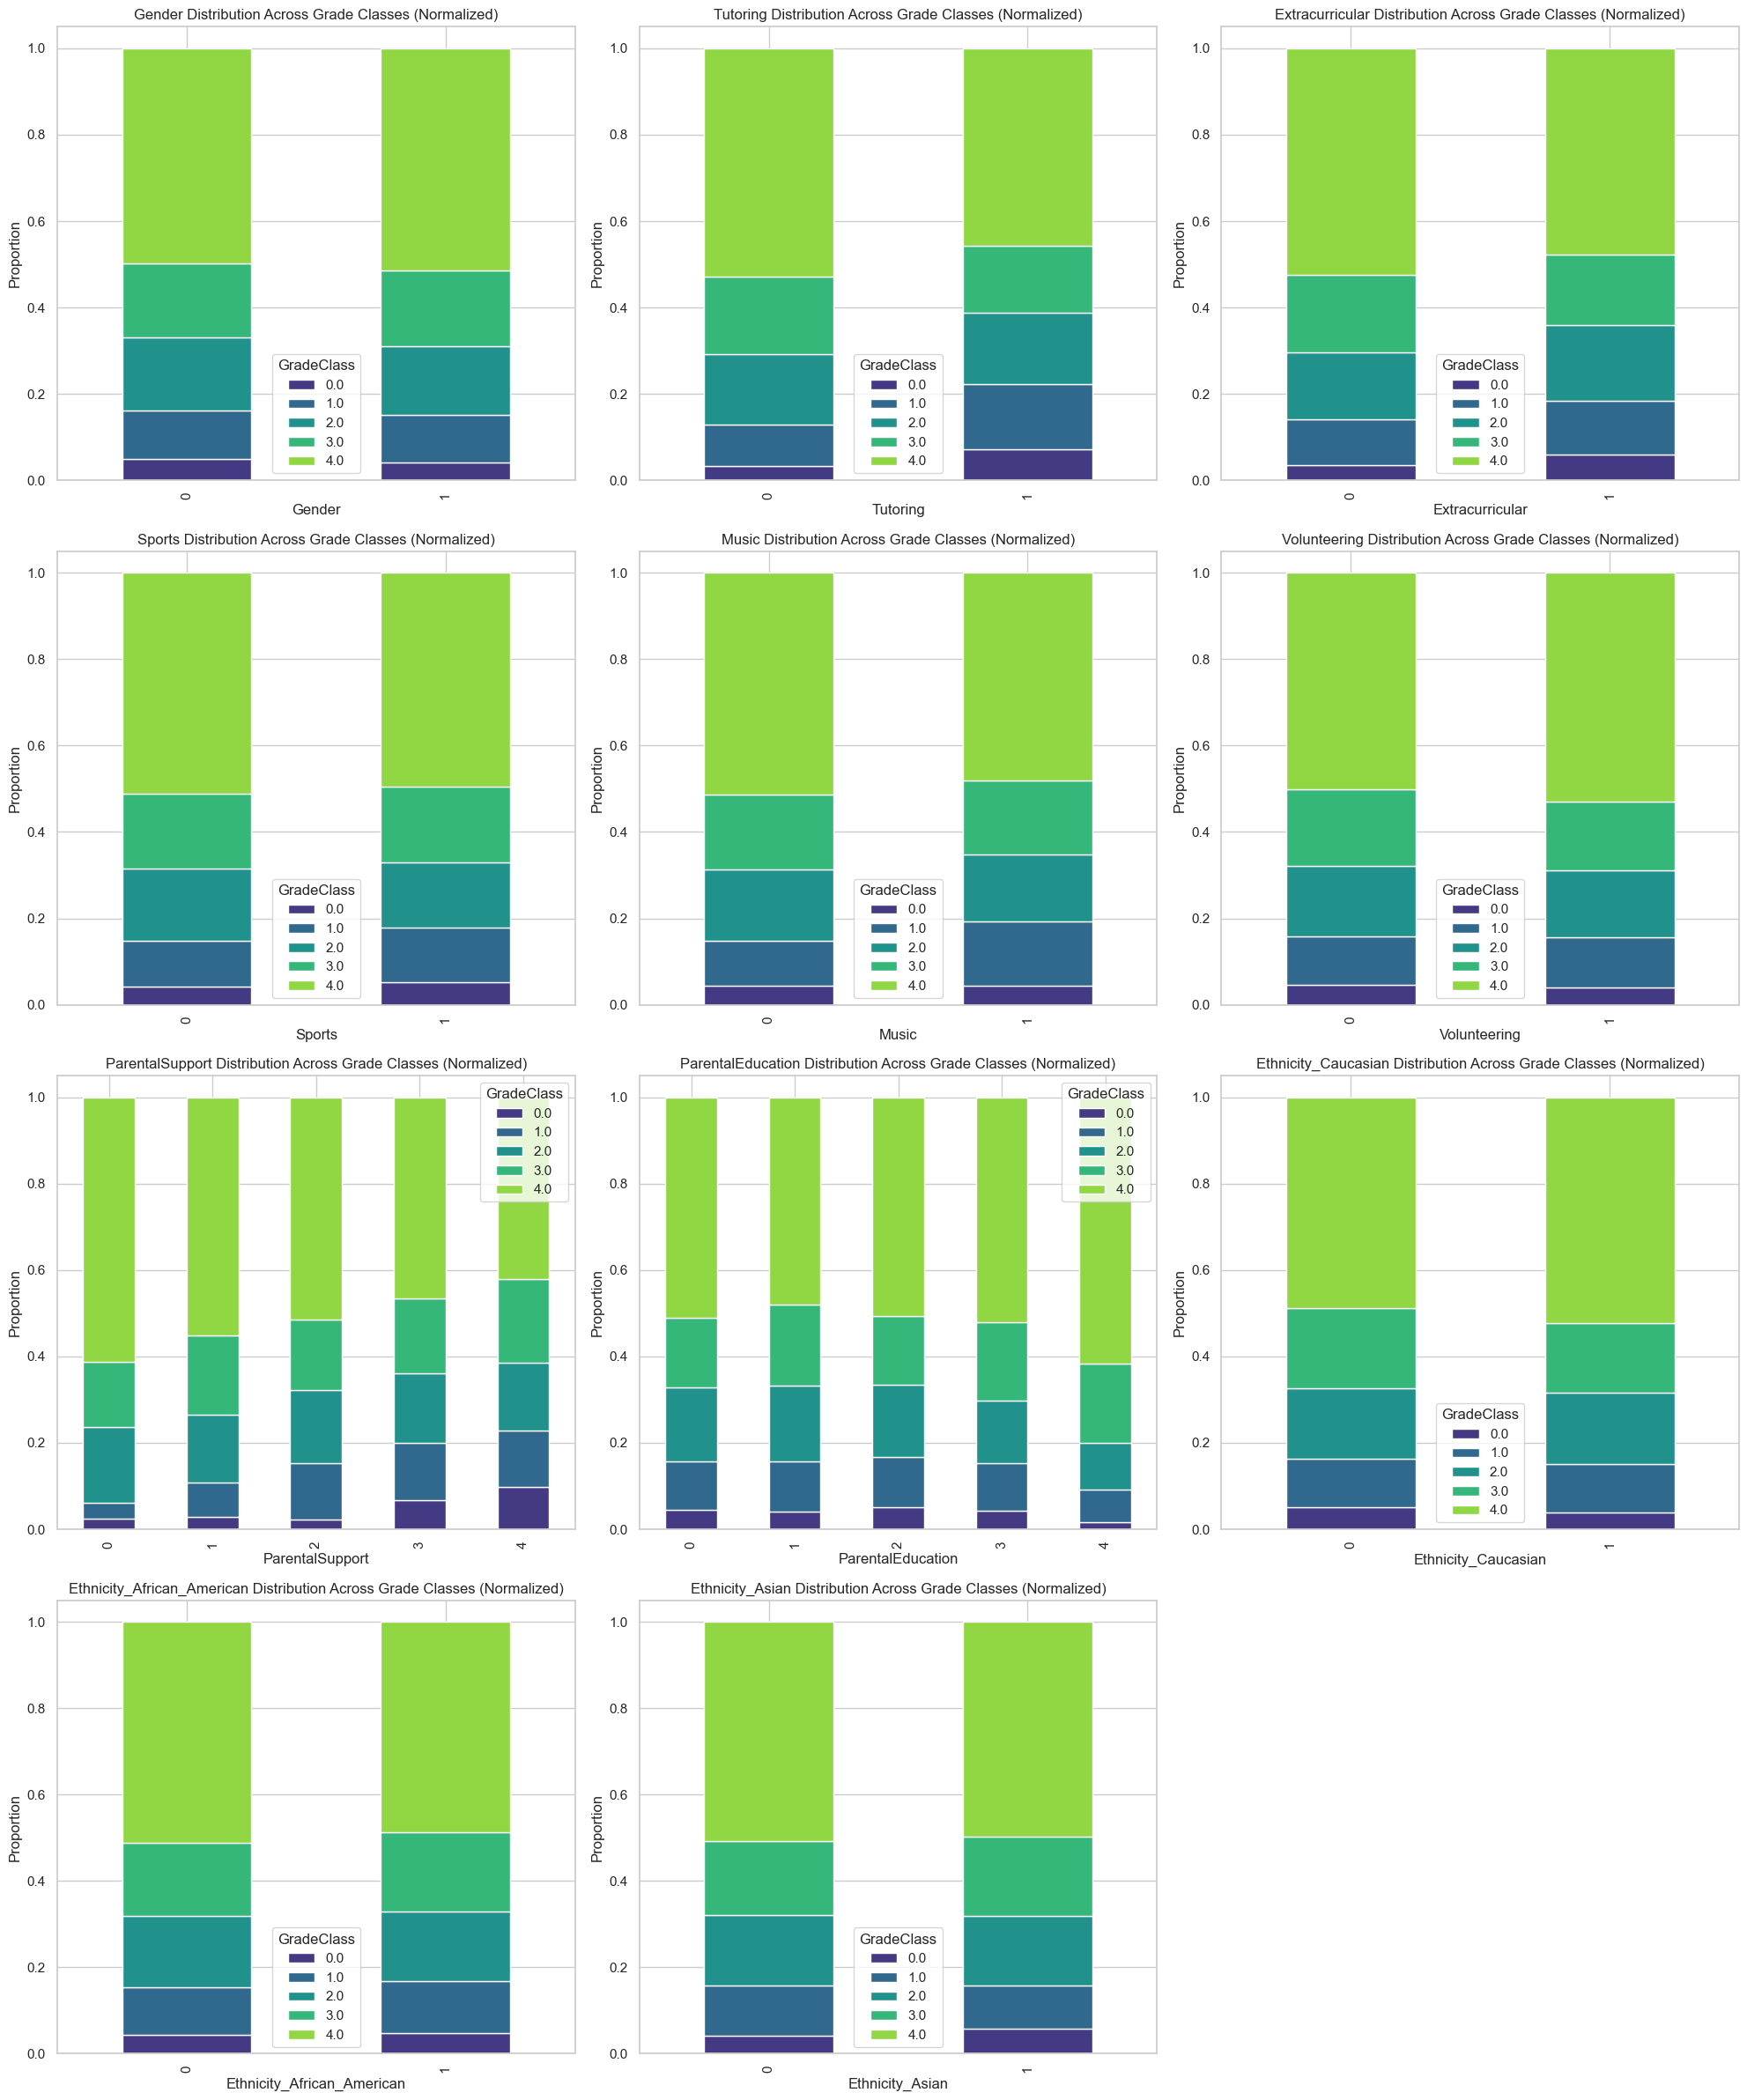

In [ ]:
# Plotting normalized feature distribution across Grade Class levels
# List of categorical features to plot
categorical_features_gradeclass = ['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering',
                                   'ParentalSupport', 'ParentalEducation', 'Ethnicity_Caucasian',
                                   'Ethnicity_African_American', 'Ethnicity_Asian']

# Defining the number of columns and calculate the number of rows
n_cols = 3
n_rows = (len(categorical_features_gradeclass) + n_cols - 1) // n_cols

# Creating subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

# Plotting normalized count plots for each feature
for i, feature in enumerate(categorical_features_gradeclass):
    # Calculate normalized counts
    category_counts = pd.crosstab(GradeClass_df[feature], GradeClass_df['GradeClass'], normalize='index')
    category_counts.plot(kind='bar', stacked=True, ax=axes[i], color=sns.color_palette('viridis', len(category_counts.columns)))
    axes[i].set_title(f'{feature} Distribution Across Grade Classes (Normalized)', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Proportion')

# Removing any empty subplots
for i in range(len(categorical_features_gradeclass), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Chi-square test for independence between categorical variables and GradeClass
for feature in categorical_features_gradeclass:
    contingency_table = pd.crosstab(GradeClass_df[feature], GradeClass_df['GradeClass'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square test for {feature} and GradeClass:')
    print(f'Chi2: {chi2}, p-value: {p}\n')

Chi-square test for Gender and GradeClass:
Chi2: 1.9153728454653411, p-value: 0.7513204328843887

Chi-square test for Tutoring and GradeClass:
Chi2: 37.75164234103285, p-value: 1.260840367380805e-07

Chi-square test for Extracurricular and GradeClass:
Chi2: 14.217072478079006, p-value: 0.006633525439525449

Chi-square test for Sports and GradeClass:
Chi2: 4.369235709031912, p-value: 0.3583355089660035

Chi-square test for Music and GradeClass:
Chi2: 7.891467870855215, p-value: 0.09563575126138266

Chi-square test for Volunteering and GradeClass:
Chi2: 1.4828991605680653, p-value: 0.8296662879352824

Chi-square test for ParentalSupport and GradeClass:
Chi2: 73.78266419541622, p-value: 2.1506704168219007e-09

Chi-square test for ParentalEducation and GradeClass:
Chi2: 14.881991324804849, p-value: 0.5332981013973794

Chi-square test for Ethnicity_Caucasian and GradeClass:
Chi2: 5.427373933337443, p-value: 0.2461875113917454

Chi-square test for Ethnicity_African_American and GradeClass:
C

In [ ]:
# t-test for GradeClass and numerical variables
''' Performing t-tests between pairs of GradeClass groups can help in distinguishing the following:
- Comparing GradeClass 0 (high GPA) with GradeClass 4 (low GPA) can help identify factors that most strongly
distinguish high-performing students from low-performing ones.
- Comparing adjacent groups, like (1, 2), can help understand factors that contribute to incremental changes in GPA.
'''
# Define numerical features for t-test, can be easily adjusted for additional variables
numerical_features_gradeclass_1 = ['StudyTimeWeekly', 'Absences']

# Function to perform t-test and print results
def t_test_between_groups(GradeClass_df, feature, group1, group2):
    group1_data = GradeClass_df[GradeClass_df['GradeClass'] == group1][feature]
    group2_data = GradeClass_df[GradeClass_df['GradeClass'] == group2][feature]
    t_stat, p_val = ttest_ind(group1_data, group2_data, nan_policy='omit')
    print(f'T-test for {feature} between GradeClass {group1} and {group2}:')
    print(f'T-statistic: {t_stat}, P-value: {p_val}\n')

# Performing t-tests between selected pairs of GradeClass groups
group_pairs = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

for feature in numerical_features_gradeclass_1:
    for group1, group2 in group_pairs:
        t_test_between_groups(GradeClass_df, feature, group1, group2)


T-test for StudyTimeWeekly between GradeClass 0 and 1:
T-statistic: 1.1345237533693175, P-value: 0.25730153349669166

T-test for StudyTimeWeekly between GradeClass 0 and 2:
T-statistic: 2.8956186860518036, P-value: 0.003951079517919726

T-test for StudyTimeWeekly between GradeClass 0 and 3:
T-statistic: 3.414909409757095, P-value: 0.0006879817122094158

T-test for StudyTimeWeekly between GradeClass 0 and 4:
T-statistic: 4.705509236947731, P-value: 2.799516034815575e-06

T-test for StudyTimeWeekly between GradeClass 1 and 2:
T-statistic: 2.316503835075351, P-value: 0.02083705015341309

T-test for StudyTimeWeekly between GradeClass 1 and 3:
T-statistic: 3.0924751512972226, P-value: 0.0020660469253145583

T-test for StudyTimeWeekly between GradeClass 1 and 4:
T-statistic: 5.117397118086804, P-value: 3.5043200177858586e-07

T-test for StudyTimeWeekly between GradeClass 2 and 3:
T-statistic: 0.8878450997515895, P-value: 0.374889931720657

T-test for StudyTimeWeekly between GradeClass 2 and 

Logistic Regression for GradeClass

In [ ]:
# Describing 'GradeClass' as an ordinal variable for logistic regression, predicting the likelihood of a student to be in a particular grade class based on independent variables.

# Preparing data
X_gradeclass = GradeClass_df[['StudyTimeWeekly', 'Absences'] + binary_vars + ['ParentalSupport', 'ParentalEducation', 'Ethnicity_Caucasian', 'Ethnicity_African_American', 'Ethnicity_Asian']]
y_gradeclass = GradeClass_df['GradeClass']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_gradeclass, y_gradeclass, test_size=0.2, random_state=42)

# Standardize the data
scaler_Log_Reg = StandardScaler()
X_train_scaled_Log_Reg = scaler_Log_Reg.fit_transform(X_train)
X_test_scaled_Log_Reg = scaler_Log_Reg.transform(X_test)

# Logistic Regression Model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_model.fit(X_train_scaled_Log_Reg, y_train)

# Predict and evaluate
y_pred_Log_Reg = logistic_model.predict(X_test_scaled_Log_Reg)
accuracy = accuracy_score(y_test, y_pred_Log_Reg)
print(f'Accuracy of logistic regression model: {accuracy}')
print(classification_report(y_test, y_pred_Log_Reg))

Accuracy of logistic regression model: 0.6847599164926931
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.38      0.41      0.40        49
         2.0       0.53      0.56      0.55        85
         3.0       0.55      0.37      0.44        86
         4.0       0.84      0.96      0.90       237

    accuracy                           0.68       479
   macro avg       0.46      0.46      0.46       479
weighted avg       0.65      0.68      0.66       479



# 7. Causal Inference with Propensity Scores

Let's run a Causal Inference test to see if the independent variable of highest Feature Importance value, 'Absences', is causal.

In [ ]:
# Generating a new dataframe for model
causal_df = corrected_df.copy()

# Creating a multi-valued treatment variable, with levels of Absences: Low, Medium, High
causal_df['Absences_Level'] = pd.cut(causal_df['Absences'], bins=[-1, 5, 15, 30], labels=['Low', 'Medium', 'High'], include_lowest=True)

# Encoding treatment variable as categorical
causal_df['Absences_Level'] = causal_df['Absences_Level'].astype('category').cat.codes

# Generalized Propensity Score Model
X_ps = causal_df[['StudyTimeWeekly', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music']]
y_ps = causal_df['Absences_Level']

# Fitting a multinomial logistic regression model
ps_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
ps_model.fit(X_ps, y_ps)
propensity_scores = ps_model.predict_proba(X_ps)

# Adding propensity scores to the dataframe
for i, level in enumerate(['Low', 'Medium', 'High']):
    causal_df[f'propensity_score_{level}'] = propensity_scores[:, i]

# Matching using nearest neighbors within each treatment group
def match_and_estimate(causal_df, treatment_level):
    treated = causal_df[causal_df['Absences_Level'] == treatment_level]
    control = causal_df[causal_df['Absences_Level'] != treatment_level]

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[[f'propensity_score_{t}' for t in ['Low', 'Medium', 'High']]])
    distances, indices = nn.kneighbors(treated[[f'propensity_score_{t}' for t in ['Low', 'Medium', 'High']]])

    matched_control_indices = indices.flatten()
    matched_control = control.iloc[matched_control_indices]

    matched_df = pd.concat([treated, matched_control], ignore_index=True)

    treated_outcomes = matched_df[matched_df['Absences_Level'] == treatment_level]['GPA']
    control_outcomes = matched_df[matched_df['Absences_Level'] != treatment_level]['GPA']
    treatment_effect = treated_outcomes.mean() - control_outcomes.mean()

    return treatment_effect

# Estimate treatment effects for each level of Absences
for level in range(3):
    treatment_effect = match_and_estimate(causal_df, level)
    print(f'Estimated treatment effect of Absences Level {level} on GPA: {treatment_effect}')

Estimated treatment effect of Absences Level 0 on GPA: 1.4961819164309107
Estimated treatment effect of Absences Level 1 on GPA: 0.657932199813624
Estimated treatment effect of Absences Level 2 on GPA: -1.4483302620903689


In [ ]:
# Generating a new dataframe for model
causal_df = corrected_df.copy()

# Creating a multi-valued treatment variable, with levels of Absences: Low, Medium, High
causal_df['Absences_Level'] = pd.cut(causal_df['Absences'], bins=[-1, 5, 15, 30], labels=['Low', 'Medium', 'High'], include_lowest=True)

# Encoding treatment variable as categorical
causal_df['Absences_Level'] = causal_df['Absences_Level'].astype('category').cat.codes

# Generalized Propensity Score Model
X_ps = X_ps = causal_df.drop(columns=['GPA', 'Absences_Level', 'Absences'])
y_ps = causal_df['Absences_Level']

# Fitting a multinomial logistic regression model
ps_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
ps_model.fit(X_ps, y_ps)
propensity_scores = ps_model.predict_proba(X_ps)

# Adding propensity scores to the dataframe
for i, level in enumerate(['Low', 'Medium', 'High']):
    causal_df[f'propensity_score_{level}'] = propensity_scores[:, i]

# Matching using nearest neighbors within each treatment group
def match_and_estimate(causal_df, treatment_level):
    treated = causal_df[causal_df['Absences_Level'] == treatment_level]
    control = causal_df[causal_df['Absences_Level'] != treatment_level]

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[[f'propensity_score_{t}' for t in ['Low', 'Medium', 'High']]])
    distances, indices = nn.kneighbors(treated[[f'propensity_score_{t}' for t in ['Low', 'Medium', 'High']]])

    matched_control_indices = indices.flatten()
    matched_control = control.iloc[matched_control_indices]

    matched_df = pd.concat([treated, matched_control], ignore_index=True)

    treated_outcomes = matched_df[matched_df['Absences_Level'] == treatment_level]['GPA']
    control_outcomes = matched_df[matched_df['Absences_Level'] != treatment_level]['GPA']
    treatment_effect = treated_outcomes.mean() - control_outcomes.mean()

    return treatment_effect

# Estimate treatment effects for each level of Absences
for level in range(3):
    treatment_effect = match_and_estimate(causal_df, level)
    print(f'Estimated treatment effect of Absences Level {level} on GPA: {treatment_effect}')

Estimated treatment effect of Absences Level 0 on GPA: 0.8300695321531242
Estimated treatment effect of Absences Level 1 on GPA: 0.32338452837663856
Estimated treatment effect of Absences Level 2 on GPA: -0.9800209448711348


The causal inference analysis using propensity score matching aims to estimate the treatment effect of different levels of absences (Low, Medium, High) on GPA.

- At low Absences level (Level 0), the estimated treatment effect is 1.496 GPA points higher compared to students with medium or high levels of absences. This suggests a strong positive effect of low absences on GPA.
- At medium Absences level (Level 1), treatment effect is 0.657 GPA points higher compared to students with low or high levels of absences, suggesting a moderate positive effect of medium absences on GPA.
- Students with high levels of absences (Level 2) have a GPA that is, on average, -1.448 points compared to students with low or medium levels of absences. This suggests a strong negative effect of high absences on GPA.

# 8. Bayesian Regression

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    GPA   No. Observations:                 2392
Model:                            GLM   Df Residuals:                     2387
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                        0.057980
Method:                          IRLS   Log-Likelihood:                 14.190
Date:                Sat, 17 Aug 2024   Deviance:                       138.40
Time:                        13:57:22   Pearson chi2:                     138.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9062      0.005    3

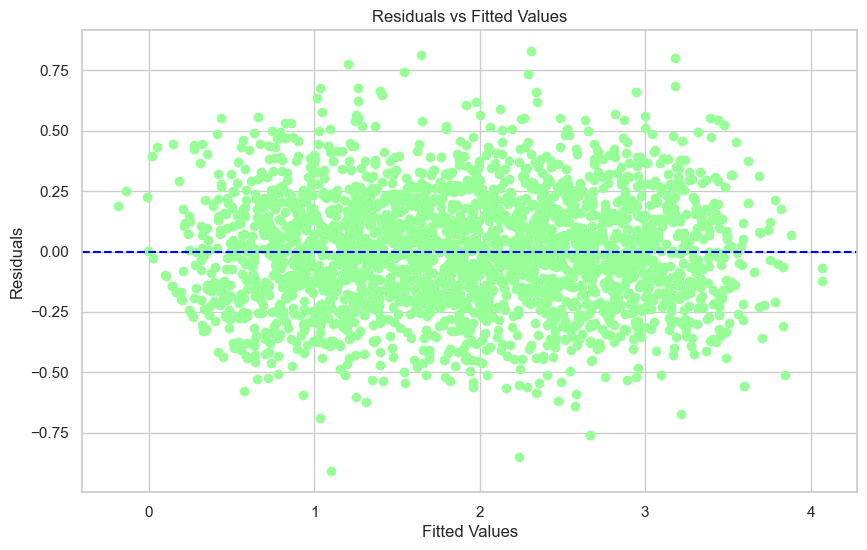

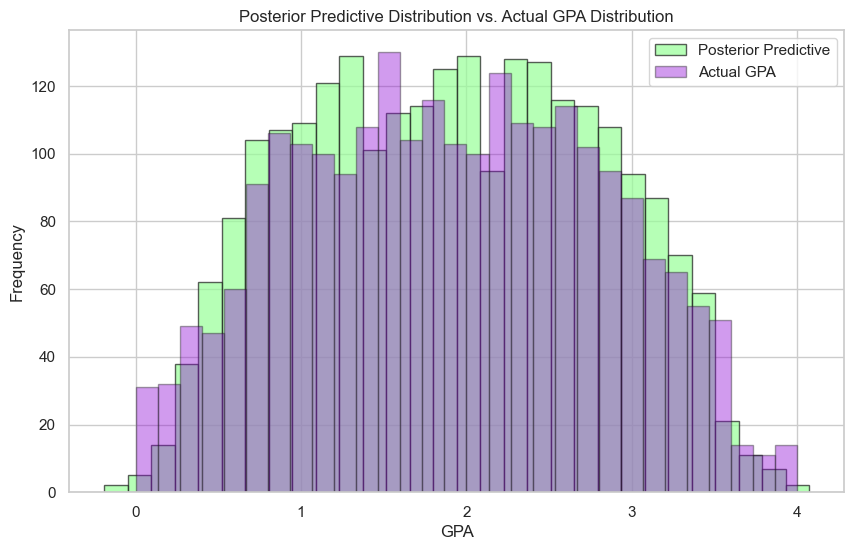

In [ ]:
# Standardizing the predictors
# Selecting independent variables based on theoretical relevance and VIF analysis
selected_vars = ['Absences', 'ParentalSupport', 'StudyTimeWeekly', 'Tutoring']

# Ensuring the target variable (GPA) is not included
X_Bayesian = corrected_df[selected_vars]
y_Bayesian = corrected_df['GPA']

# Standardizing the independent variables
scaler = StandardScaler()
X_scaled_Bayesian = scaler.fit_transform(X_Bayesian)
X_scaled_Bayesian = pd.DataFrame(X_scaled_Bayesian, columns=X_Bayesian.columns)

# Adding a constant to the predictors
X_scaled_Bayesian = sm.add_constant(X_scaled_Bayesian)

# Bayesian Regression using statsmodels
model_Bayesian = sm.GLM(y_Bayesian, X_scaled_Bayesian, family=sm.families.Gaussian())
bayesian_results = model_Bayesian.fit()

# Summary of the results
print(bayesian_results.summary())

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(bayesian_results.fittedvalues, bayesian_results.resid_response, color='#98FF98')
plt.axhline(0, color='blue', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plotting the posterior predictive distribution and actual GPA distribution
plt.figure(figsize=(10, 6))

# Posterior Predictive Distribution
plt.hist(bayesian_results.fittedvalues, bins=30, edgecolor='k', alpha=0.7, color='#98FF98', label='Posterior Predictive')
# Actual GPA Distribution
plt.hist(y_Bayesian, bins=30, edgecolor='k', alpha=0.4, color='#8e05d5', label='Actual GPA')

plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Distribution vs. Actual GPA Distribution')
plt.legend()
plt.show()

The metrics in the Generalized Linear Model Regression indicate a pretty good fit:
- A high Log-Likelihood (502.00) indicates a better fit.
- Pseudo R-squared (CS) (1.000), measuring how well the model explains the variability of the dependent variable, where value of 1 indicates a perfect fit.
Looking at the variables metrics, such as standard errors, z-values, p-values, indicate that StudyTimeWeekly, Absences, Tutoring, and ParentalSupport are the highest predictors, with low p-values and relatively high coefficients.
- Posterior Predictive Distribution Plot shows the distribution of the predicted values from the Bayesian regression, suggesting that the predicted GPA values follow a roughly normal distribution centered around the mean GPA value.
- Residuals vs. Fitted Values Plot - The residuals are scattered randomly around the horizontal line at zero, indicating that the model's assumptions of linearity and homoscedasticity (constant variance) are likely satisfied.


Key Takeaways:
- Significant Predictors: Study time, absences, tutoring, parental support, extracurricular activities, sports, and music participation are significant predictors of GPA.

- Non-significant Predictors: Gender, parental education, volunteering, and ethnicity do not significantly affect GPA in this model.
